# Предсказание вероятности возврата кредита клиентом компании

Предоставлена информация из анкетных данных заемщиков, данных об итогах уже выданных кредитов и факт наступления дефолта.

Цель: предсказать возврат кредита клиентом с просрочкой не более 90 дней.

Задачи: построить эффективную скоринговую модель, которая бы предсказывала наступление дефолта клиента. Для этого используем различные алгоритмы классификации: логистическую регрессию, XGBoost и CatBoost, посмотрим, какая из них выдаст лучший результат.

Поэтапное описание работы: -анализ исходных данных (проверка на дубликаты и выбросы); -корреляционный анализ с целью выявить, какие признаки оставить для постороения модели; -построение наивной модели; -подготовка данных для машинного обучения; -построение модели Логистичесткой регргессии; -построение модели XGBoost; -построение модели CatBoost; -подбор параметров для модели XGBoost

В качестве метрики для оценки качества модели был взят коэффициент Gini, который оценивает ранжирующую способность модели.

#1. Установим и импортируем необходимые библиотеки:

In [ ]:
pip install hyperopt

In [ ]:
 pip install imblearn

In [ ]:
!pip install catboost

     |████████████████████████████████| 65.8MB 60kB/s 


In [ ]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from itertools import combinations
from scipy.stats import ttest_ind

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb 
from xgboost import plot_importance
from matplotlib import pyplot

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV

from catboost import CatBoostClassifier
from catboost import Pool

from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from sklearn.model_selection import cross_val_score

import os

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)


In [ ]:
# Зафиксируем Random_seed для воспроизводимости экспериментов
random_seed = 42

In [ ]:
# Зафиксируем версию пакетов для воспроизводимости экспериментов
!pip freeze > requirements.txt

##1.2 Определим функции:

In [ ]:
#Таблица метрик модели
def metrics_total(y_true, y_pred, y_pred_prob):
    """Функция выводит в виде датафрейма значения основных метрик классификации"""
    dct_metrics = {}
    P = np.sum(y_true==0)
    N = np.sum(y_true==1)
    TP = np.sum((y_true==0)&(y_pred==0))
    TN = np.sum((y_true==1)&(y_pred==1))
    FP = np.sum((y_true==1)&(y_pred==0))
    FN = np.sum((y_true==0)&(y_pred==1))
    
    dct_metrics['P'] = ['Positive', P,' БЕЗ Дефолта']
    dct_metrics['N'] = ['Negative', N,'Дефолт']
    dct_metrics['TP'] = ['True positive', TP, 'Истинно НЕ дефолтные']
    dct_metrics['TN'] = ['True Negative', TN, 'Истинно дефолтные']
    dct_metrics['FP'] = ['False Positive', FP,'Ложно НЕ дефолтные']
    dct_metrics['FN'] = ['False Negative', FN,'Ложно дефолтные']
    dct_metrics['Accuracy'] = ['Accuracy', accuracy_score(y_true, y_pred)*100,'Accuracy=(TP+TN)/(TP+TN+FP+FN)*100%']
    dct_metrics['Precision'] = ['Precision',precision_score(y_true, y_pred)*100,'Точность = TP/(TP+FP)*100%'] 
    dct_metrics['Recall'] = ['Recall', recall_score(y_true, y_pred)*100,'Полнота = TP/(TP+FN)*100%']
    dct_metrics['F1-score'] = ['F-мера', f1_score(y_true, y_pred)*100,'Среднее гармоническое Precision и Recall']
    dct_metrics['ROC_AUC'] = ['ROC_AUC', roc_auc_score(y_true, y_pred_prob)*100,'ROC-AUC']    
    dct_metrics['Gini'] = ['Gini', (2*roc_auc_score(y_true, probs) - 1)*100, 'Коэффициент Gini'] 
    temp_df = pd.DataFrame.from_dict(dct_metrics, orient='index', columns=['Metrics', 'Result', 'Description'])
    display(temp_df)

In [ ]:
#Таблица метрик для сравнения результатов каждой модели
def cumulated_res(data, col, y_true, y_pred, probs):
    dct = {}
    dct['Accuracy'] = ['Accuracy', accuracy_score(y_true, y_pred)*100]
    dct['Precision'] = ['Precision',precision_score(y_true, y_pred)*100] 
    dct['Recall'] = ['Recall', recall_score(y_true, y_pred)*100]
    dct['F1-score'] = ['F1-score', f1_score(y_true, y_pred)*100]
    dct['Gini'] = ['Gini', (2*roc_auc_score(y_true, probs) - 1)*100] 
    dct['ROC_AUC'] = ['ROC_AUC', roc_auc_score(y_true, probs)*100] 
     
    temp_cum_df = pd.DataFrame.from_dict(dct, orient='index', columns=['Metrics', col])
    data = data.merge(temp_cum_df, on = 'Metrics')
    return data

In [ ]:
#График confusion matrix
def conf_matr(y_true, y_pred):
    color_text = plt.get_cmap('binary_r')(0.95)
    class_names = ['Non-Default', 'Default']
    cm = confusion_matrix(y_true, y_pred)
    data = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), title="Confusion Matrix")
    ax.title.set_fontsize(15)
    group_names = ['TP','FP','FN','TN']
    sns.heatmap(data, square=True, annot=True,annot_kws={"size": 20}, fmt="d", linewidths=1, cmap="Pastel1")
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor", fontsize=12)
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor", fontsize=12)
    ax.set_ylabel('Predicted Values', fontsize=14, color = color_text)
    ax.set_xlabel('Real Values', fontsize=14, color = color_text)
    b, t = plt.ylim()
    plt.ylim(b+0.5, t-0.5)
    fig.tight_layout()
    plt.show()

##1.3 Считываем данные из заранее подготовленного датасета

In [ ]:
data = pd.read_csv('df_for_model.csv')
data.head()

N_Loans  perc_amount  N_365  last_payment  N_90_365  s_Amount  \
0        1     0.620701      1             5       1.0      5300   
1        4     0.055000      4             5       1.0      9000   
2        2     0.046000      2             1       1.0      5000   
3        1     0.510000      1            67       0.0      5000   
4        1     0.320000      1            75       0.0      2000   

   s_Credit_befo_RD  s_Credit_15  s_Credit_30  s_Credit_90  s_Credit_90_RD  \
0               0.0          0.0          0.0      8589.72         8589.72   
1            9495.0          0.0          0.0         0.00         9495.00   
2            5230.0          0.0          0.0         0.00         5230.00   
3            2250.0       5300.0       5300.0      5300.00         7550.00   
4               0.0       2640.0       2640.0      2640.00         2640.00   

   Dola_RD_1  Dola_RD_2  Dola_RD_3  Dola_15_90  Dola_60_90  a_sum_Credit_700  \
0        0.0        0.0        0.0         0.0         1.0           8589.72   
1        1.0        1.0        1.0         0.0         0.0           2373.75   
2        1.0        1.0        1.0         0.0         0.0           2615.00   
3        0.0        0.0        0.0         0.0         0.0           7550.00   
4        0.0        0.0        0.0         0.0         0.0           2640.00   

   a_sum_Credit_365  a_sum_Credit_180  a_sum_Credit_90  s_Amount_30  \
0           8589.72           8589.72          8589.72            0   
1           2373.75           2373.75          2373.75         2000   
2           2615.00           2615.00          2615.00         5000   
3           7550.00           7550.00             0.00            0   
4           2640.00           2640.00             0.00            0   

   s_Amount_60  s_Amount_90  s_Amount_180  s_Amount_360  s_Amount_500  \
0            0         5300          5300          5300          5300   
1         9000         9000          9000          9000          9000   
2         5000         5000          5000          5000          5000   
3            0            0          5000          5000          5000   
4            0            0          2000          2000          2000   

   cred_hist_1  cred_hist_2  cred_hist_3  Cred_Deb_2  Cred_Deb_AmRe  \
0           69           69           69      4.2949         1.6449   
1           47            6            6      1.3564         0.0707   
2           10            8            8      1.3075         0.0575   
3          101          101          101      2.5167         0.8500   
4          107          107          107      0.8800         0.2133   

   Cred_Deb_AmRe_01  Cred_Deb_AmRe_1  Cred_Deb_Deb  a_cnt_cred_45  \
0               0.0           1.6449      0.620701            0.0   
1               0.0           0.0707      0.055000            3.0   
2               0.0           0.0575      0.046000            2.0   
3               0.0           0.8500      0.510000            0.0   
4               0.0           0.2133      0.320000            0.0   

   a_cnt_cred_90  a_cnt_cred_135  a_cnt_cred_180  a_cnt_cred_700  \
0            1.0             1.0             1.0             1.0   
1            4.0             4.0             4.0             4.0   
2            2.0             2.0             2.0             2.0   
3            0.0             1.0             1.0             1.0   
4            0.0             1.0             1.0             1.0   

   a_cnt_cred_365  miAmount_45  miAmount_90  miAmount_180  Amount_45  \
0             1.0       0.0000       2.6500        2.6500     0.0000   
1             4.0       0.2857       0.2857        0.2857     0.4286   
2             2.0       0.5000       0.5000        0.5000     0.7500   
3             1.0       0.0000       0.0000        1.6667     0.0000   
4             1.0       0.0000       0.0000        0.6667     0.0000   

   Amount_90  Amount_180  Amount_365  n_cr_1  n_cr_2  n_cr_12  ...  \
0     2.6500      2.6500

In [ ]:
df = data.copy()

#2. Построим наивную модель:

Эта модель будет предсказывать дефолт клиента по полу и возрасту заемщика. C ней будем сравнивать другие модели.

In [ ]:
# split данных
data_train, data_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['Gender', 'age']]).iterrows():
    query = f"Gender == '{row[0]}' and age == '{row[1]}'"
    predicts.append(data_train.query(query)['Default'].max())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.max())

#оцениваем точность
print(f"Точность наивной модели по метрике accuracy_score: {(accuracy_score(data_test['Default'], predicts.values[:, 0]))*100:0.2f}%")
print(f"Точность наивной модели по метрике precision_score: {(precision_score(data_test['Default'], predicts.values[:, 0]))*100:0.2f}%")
print(f"Точность наивной модели по метрике recall_score: {(recall_score(data_test['Default'], predicts.values[:, 0]))*100:0.2f}%")
print(f"Точность наивной модели по метрике f1_score: {(f1_score(data_test['Default'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике accuracy_score: 33.20%
Точность наивной модели по метрике precision_score: 33.16%
Точность наивной модели по метрике recall_score: 100.00%
Точность наивной модели по метрике f1_score: 49.80%


accuracy_score наивной модели 33%, f1_score - 49.8%

In [ ]:
predicts.sample(10)

0
1528  1.0
383   1.0
293   1.0
257   1.0
365   1.0
548   1.0
1092  1.0
1530  1.0
282   1.0
1508  1.0

Судя по всему, наша наивная модель предсказывает одни единицы.

#3. Построение моделей

##3.1 Подготовка датасета:

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


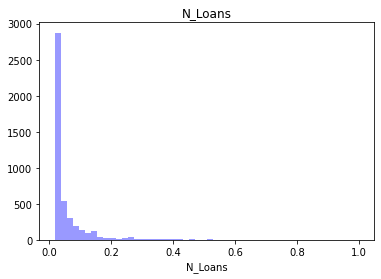

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


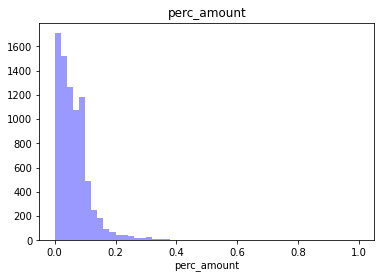

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


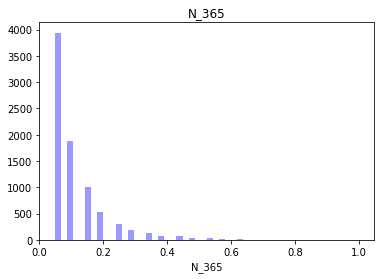

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


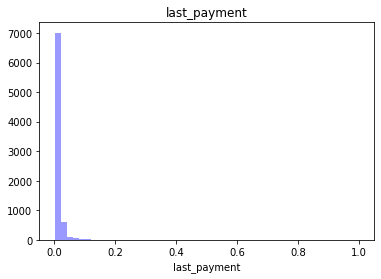

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


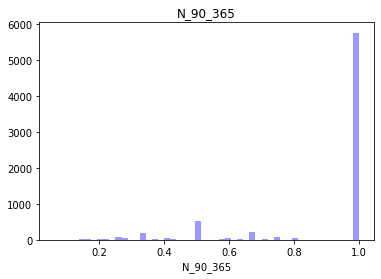

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


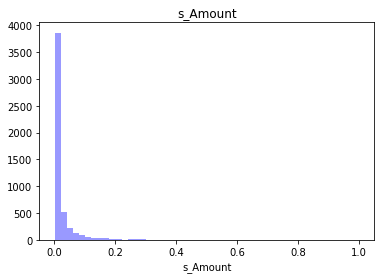

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


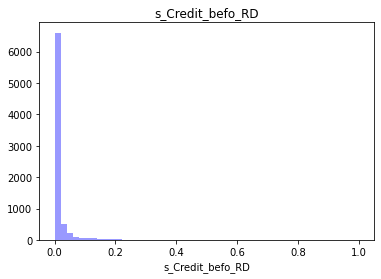

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


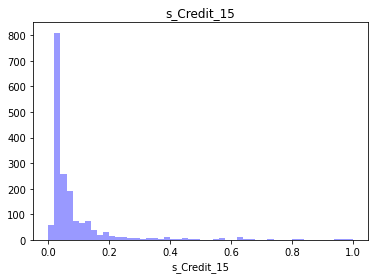

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


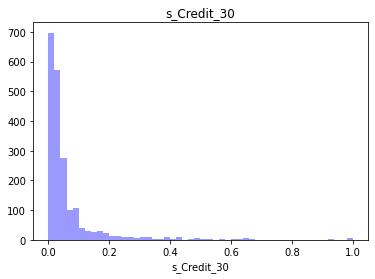

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


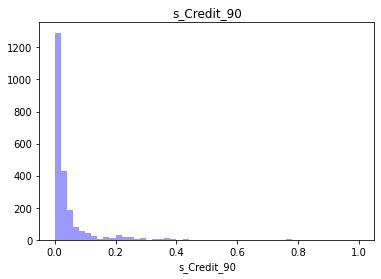

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


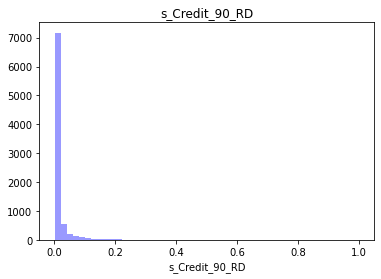

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


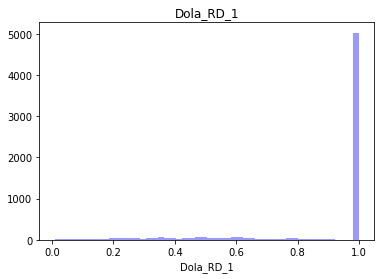

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


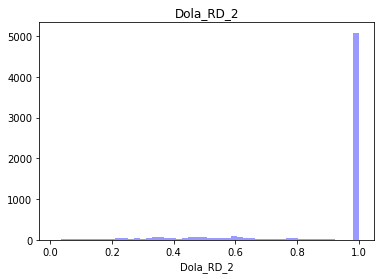

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


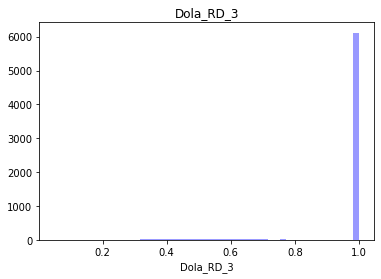

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


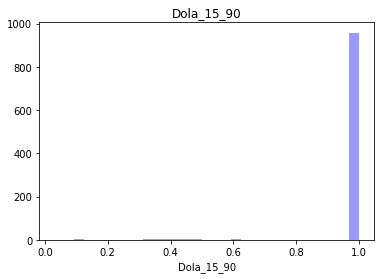

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


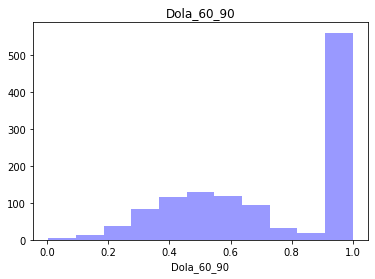

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


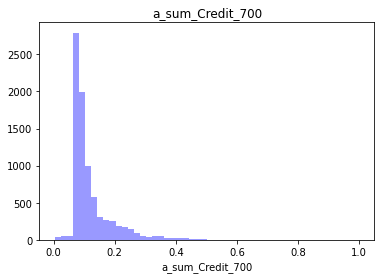

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


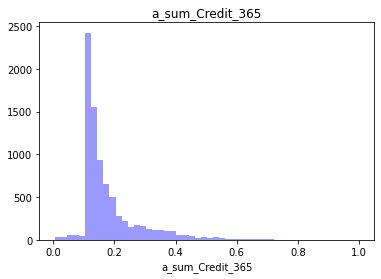

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


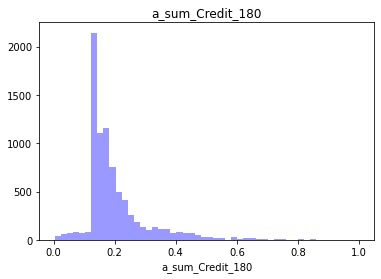

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


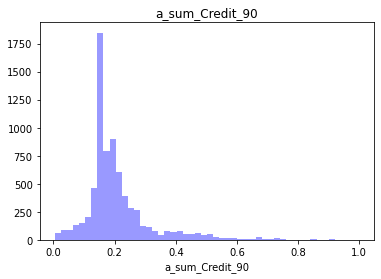

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


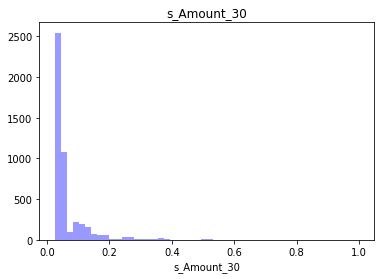

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


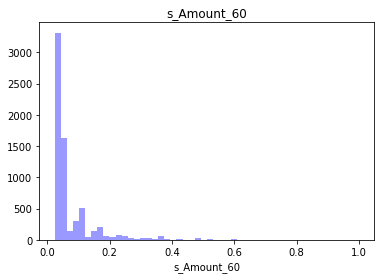

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


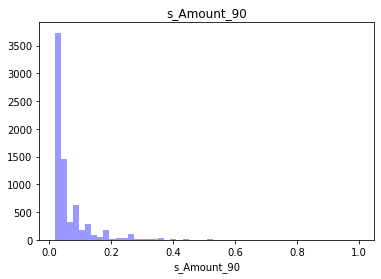

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


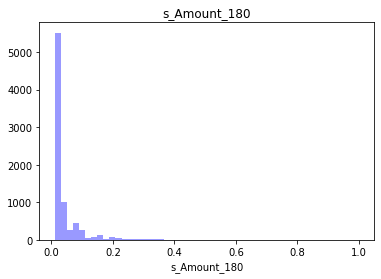

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


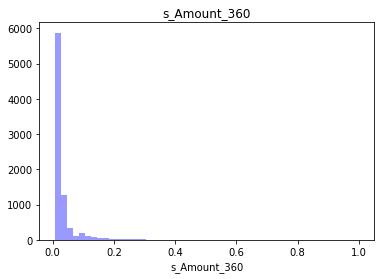

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


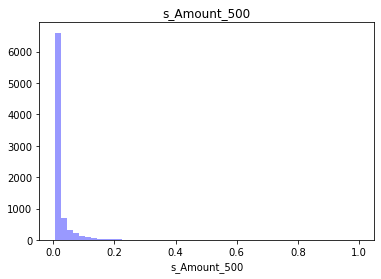

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


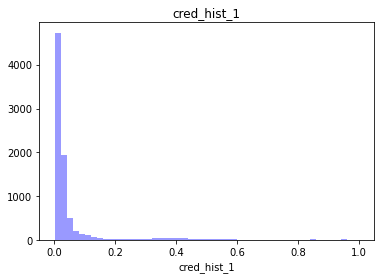

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


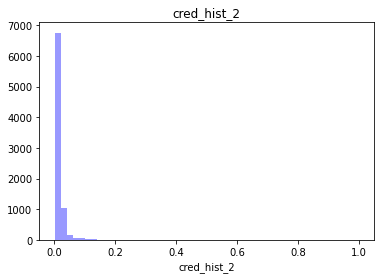

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


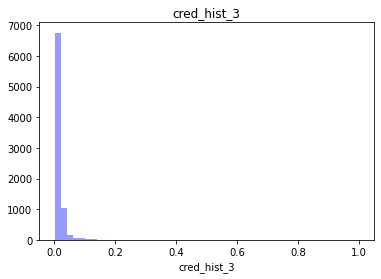

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


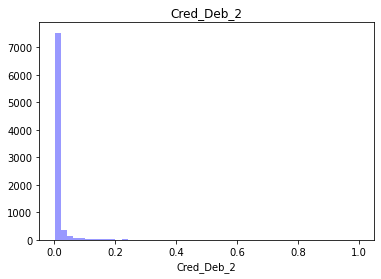

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


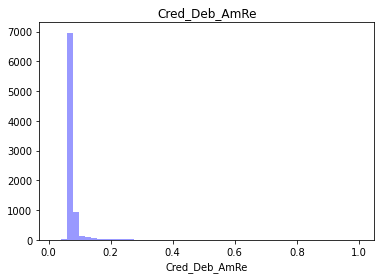

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


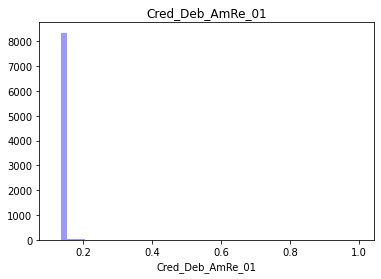

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


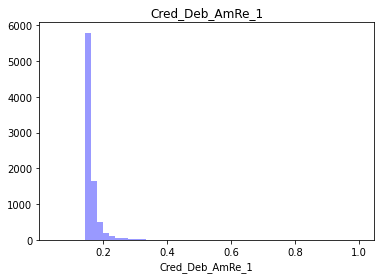

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


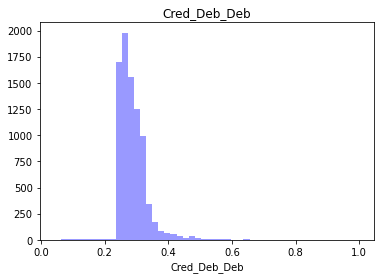

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


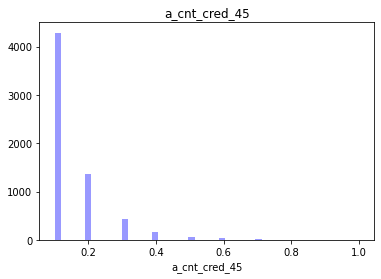

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


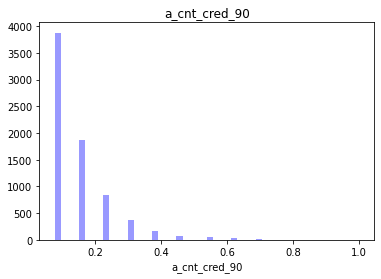

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


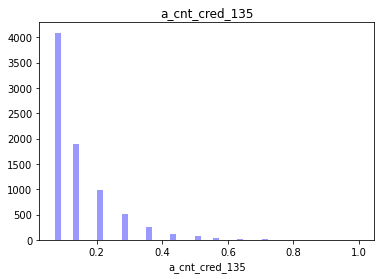

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


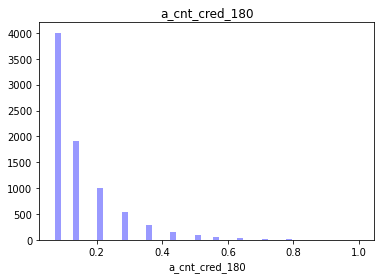

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


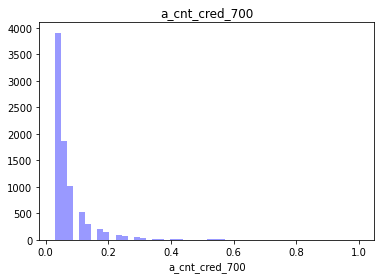

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


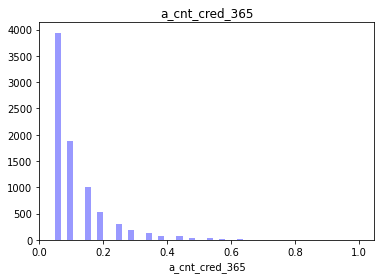

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


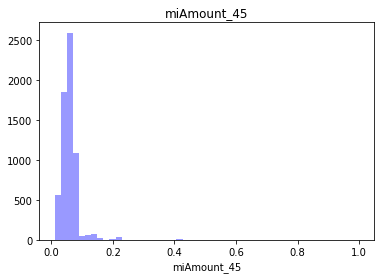

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


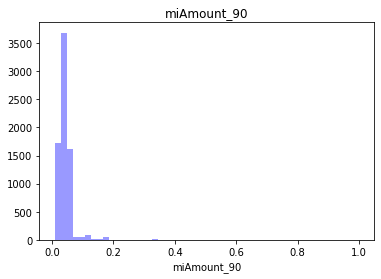

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


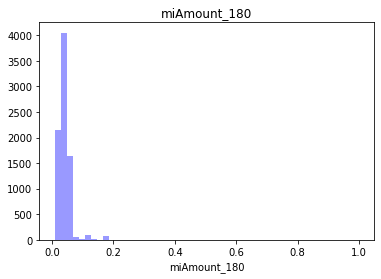

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


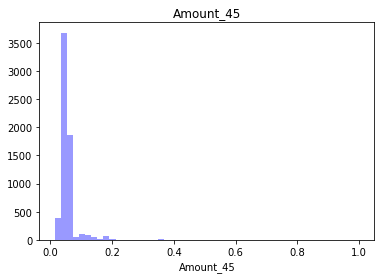

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


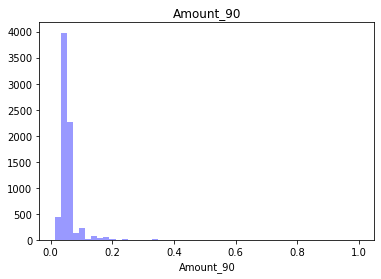

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


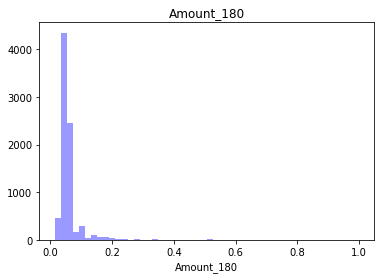

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


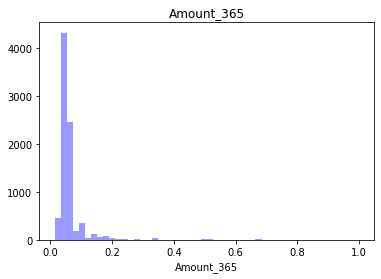

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


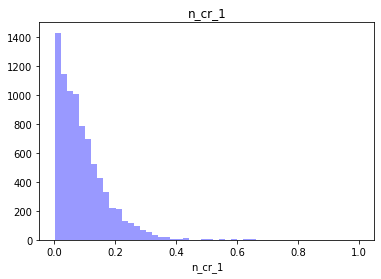

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


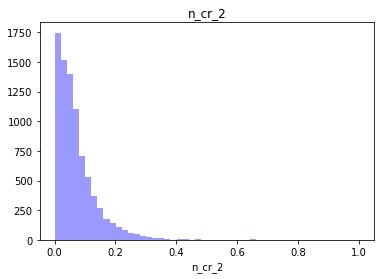

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


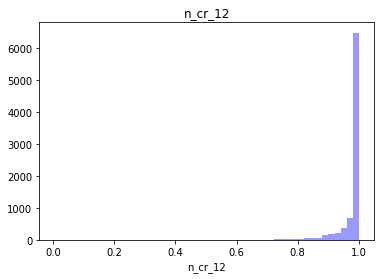

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


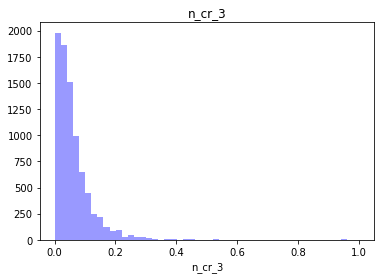

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


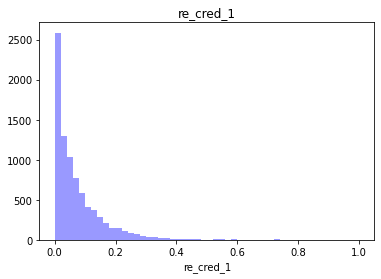

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


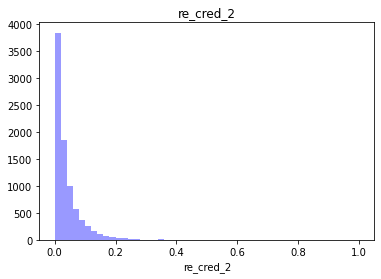

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


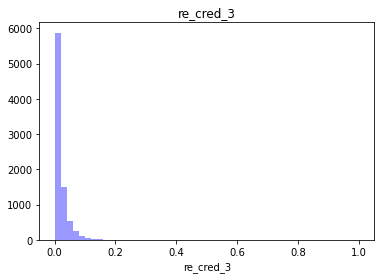

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


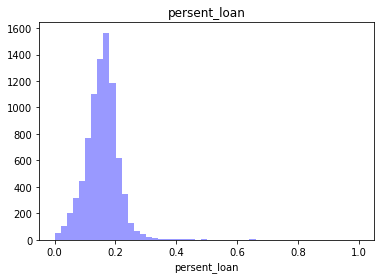

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


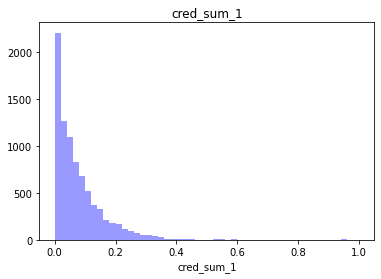

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


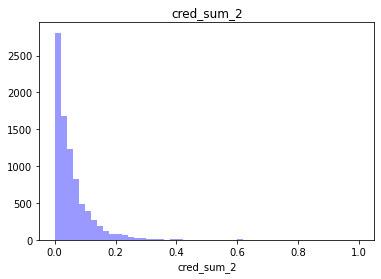

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


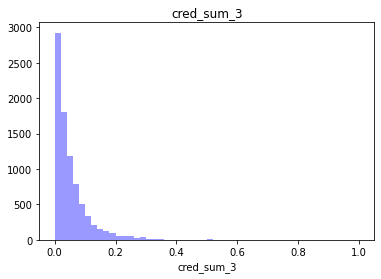

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


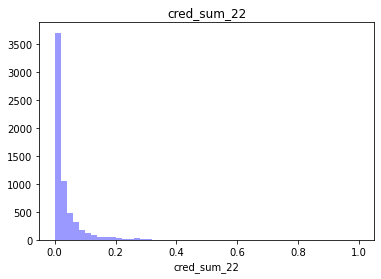

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


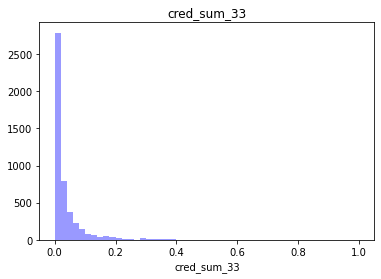

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


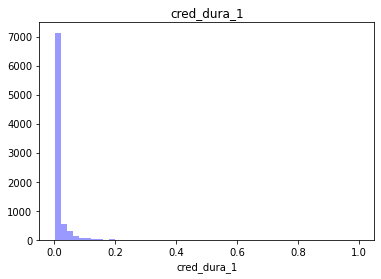

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


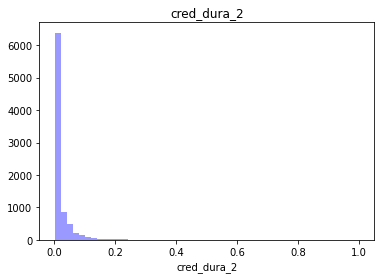

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


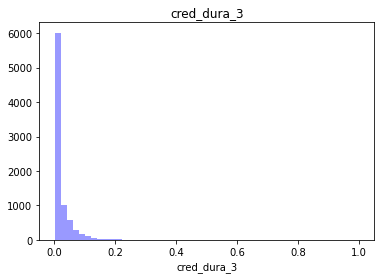

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


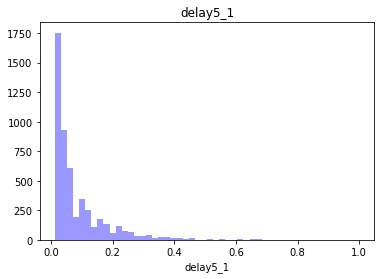

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


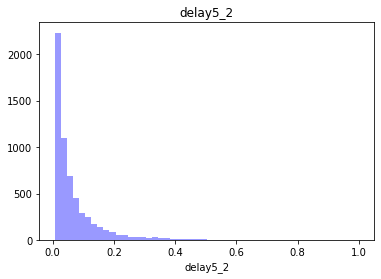

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


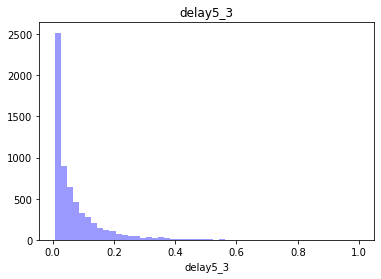

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


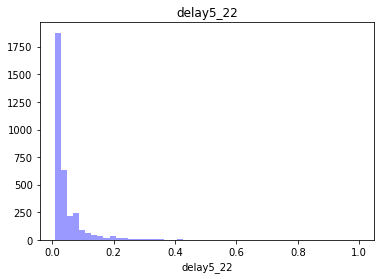

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


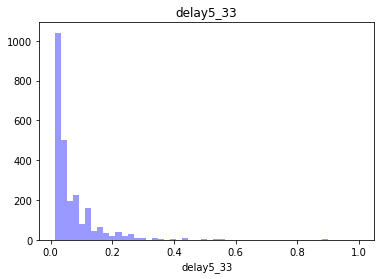

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


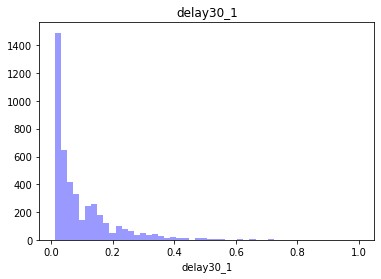

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


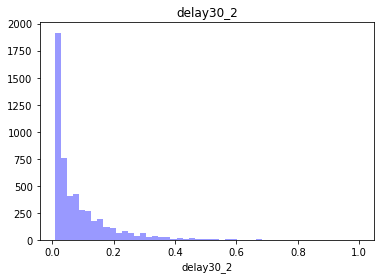

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


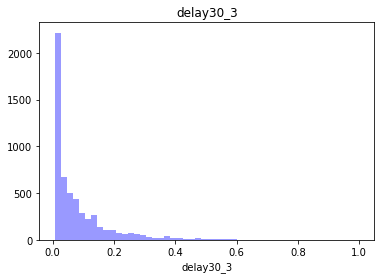

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


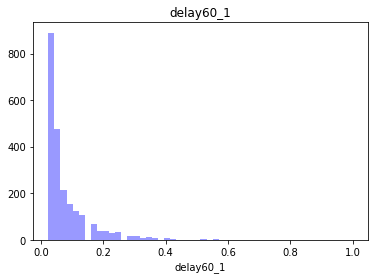

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


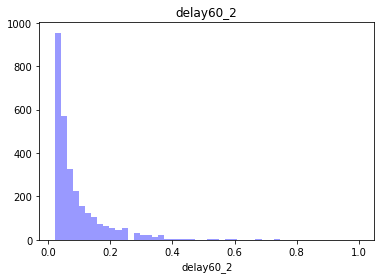

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


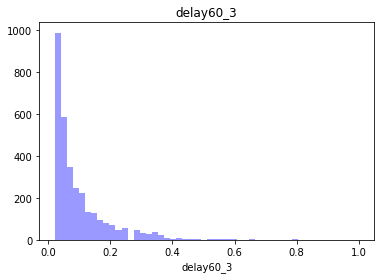

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


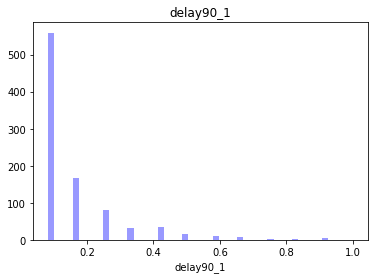

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


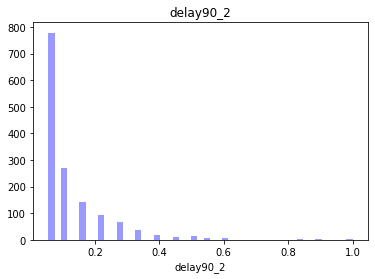

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


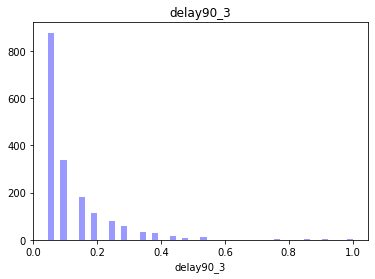

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


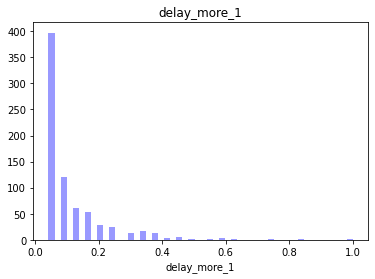

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


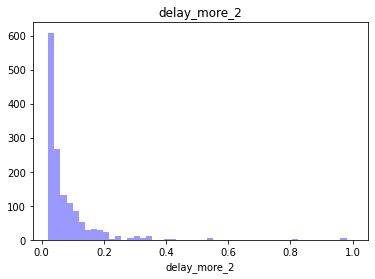

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


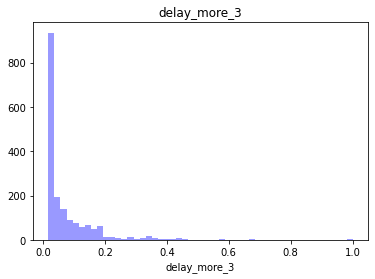

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


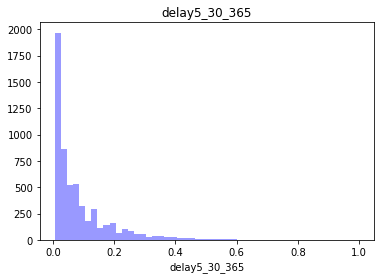

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


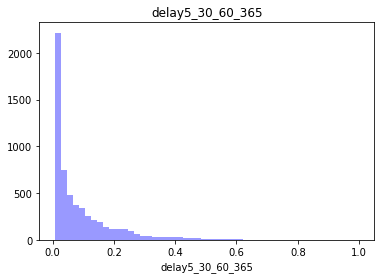

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


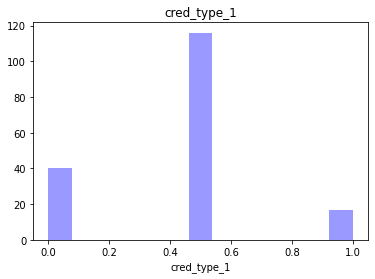

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


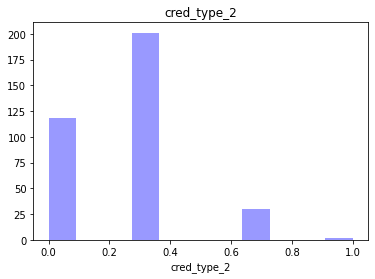

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


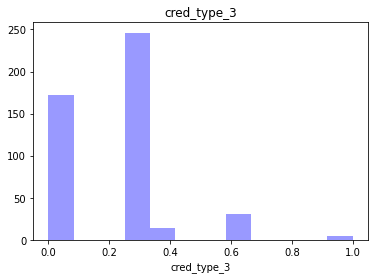

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


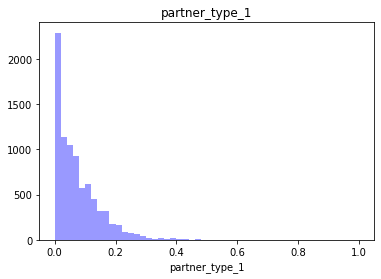

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


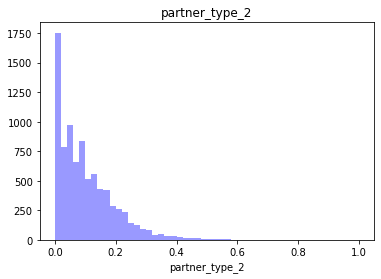

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


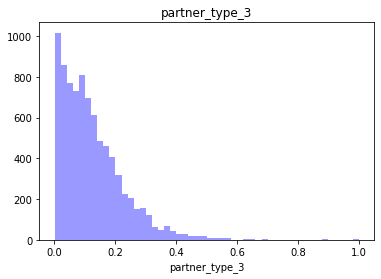

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


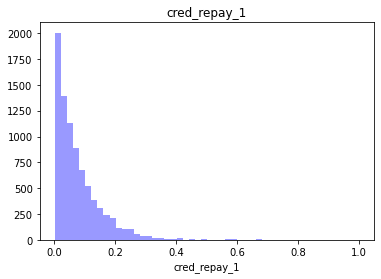

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


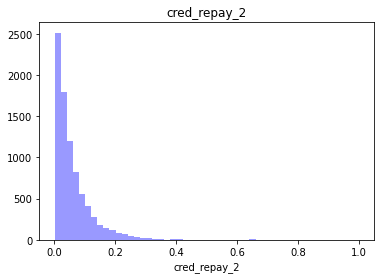

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


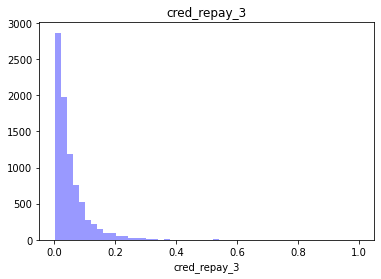

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


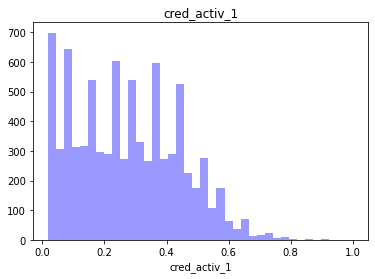

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


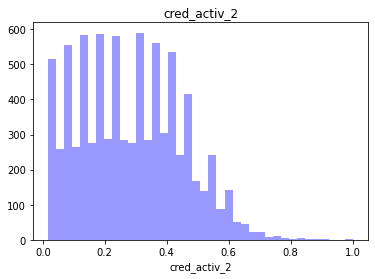

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


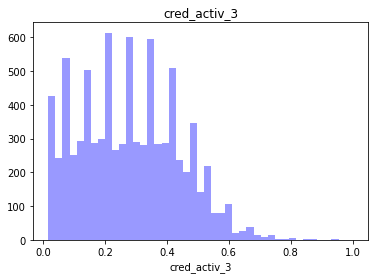

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


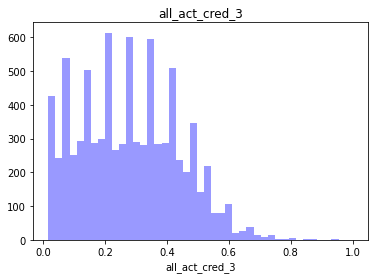

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


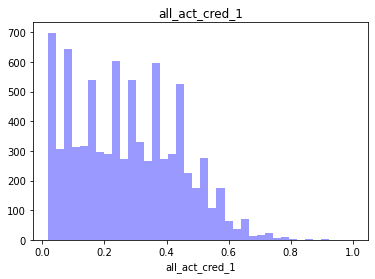

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


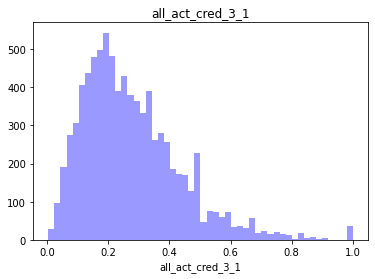

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


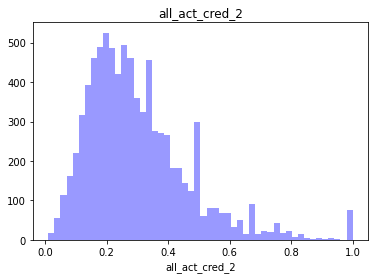

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


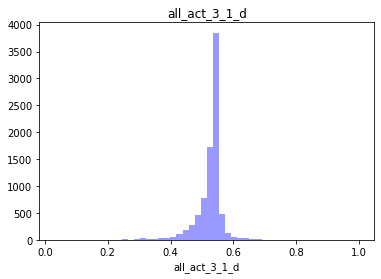

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


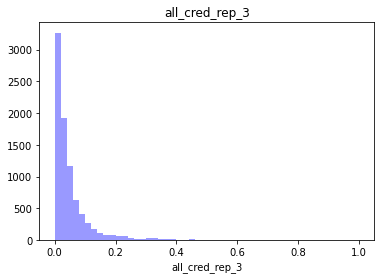

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


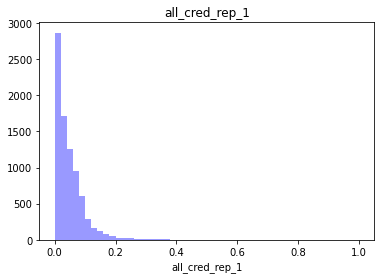

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


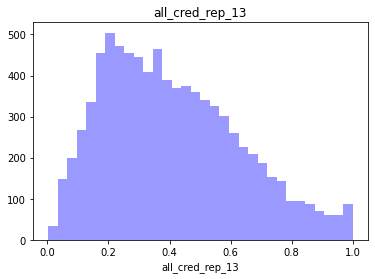

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


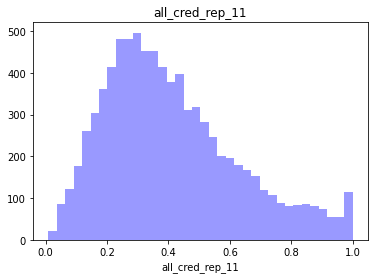

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


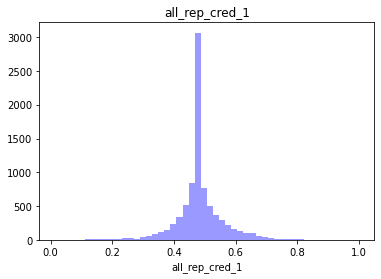

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


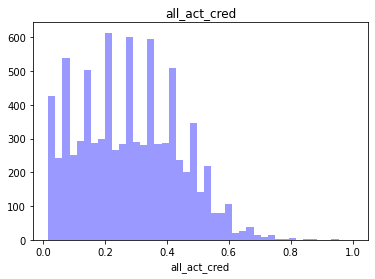

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


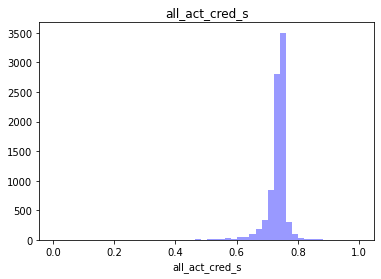

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


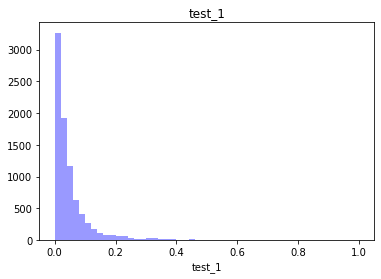

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


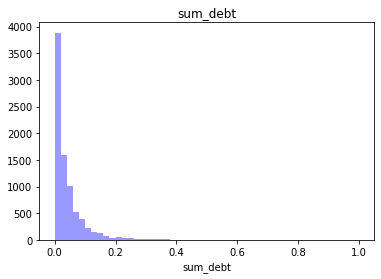

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


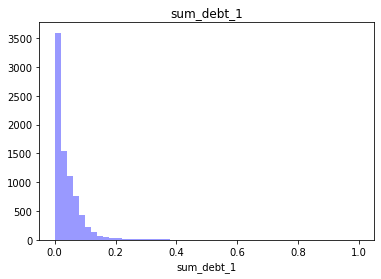

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


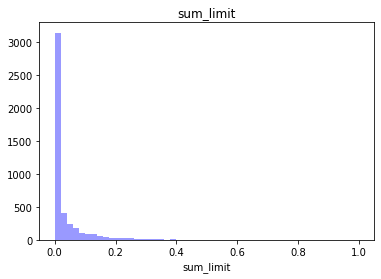

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


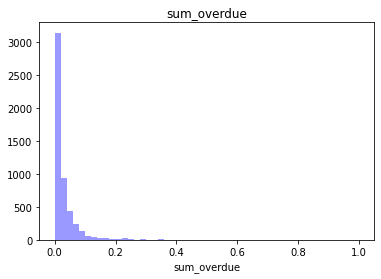

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


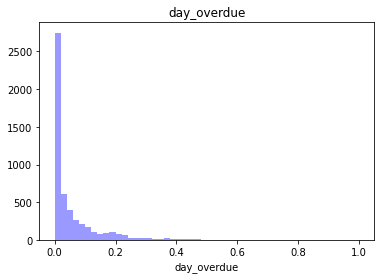

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


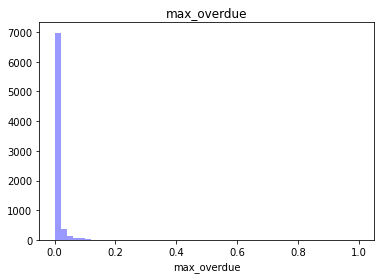

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


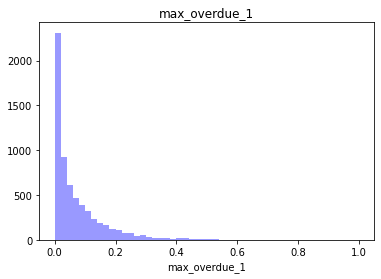

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


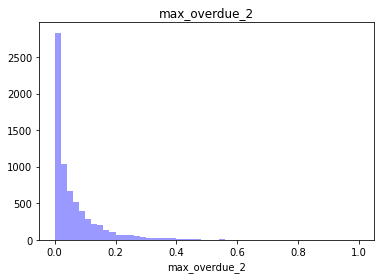

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


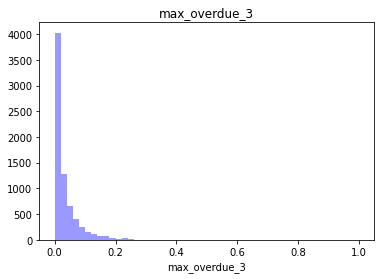

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


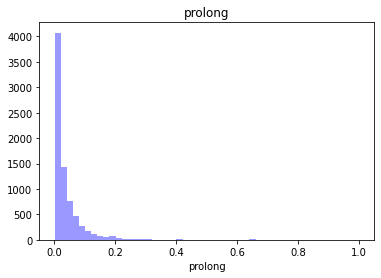

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


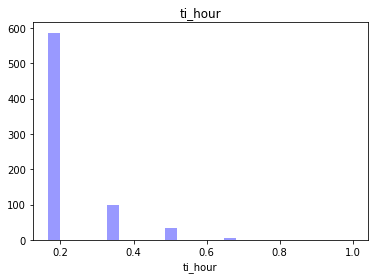

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


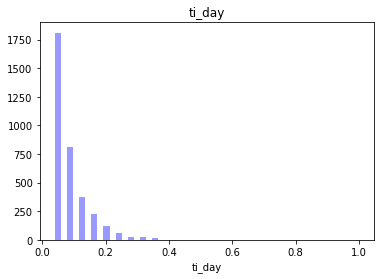

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


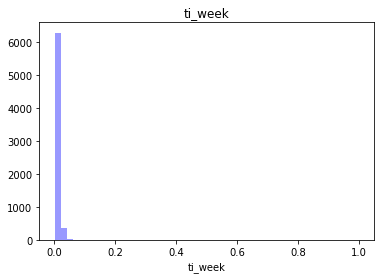

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


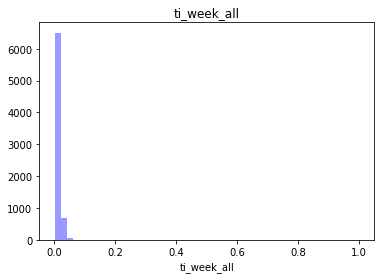

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


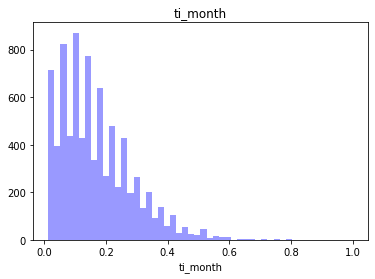

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


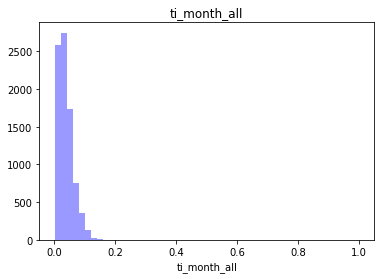

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


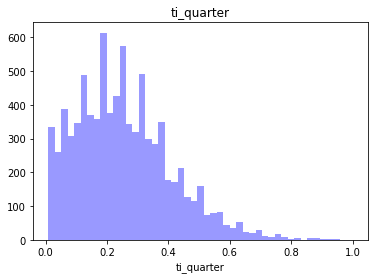

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


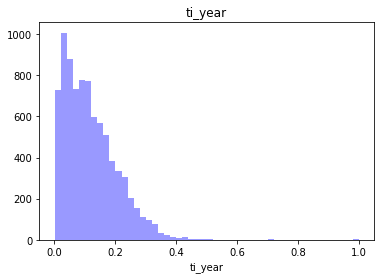

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


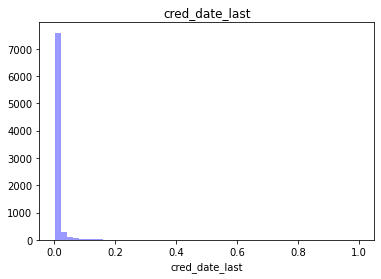

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


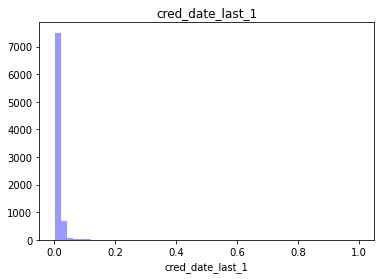

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


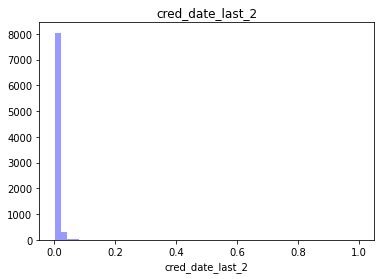

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


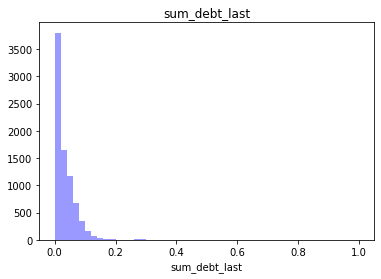

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


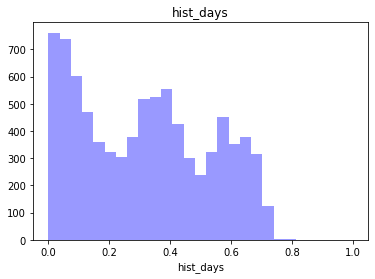

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


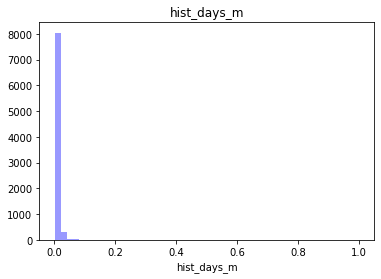

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


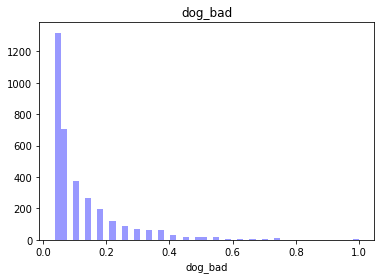

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


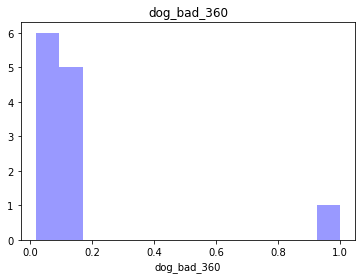

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


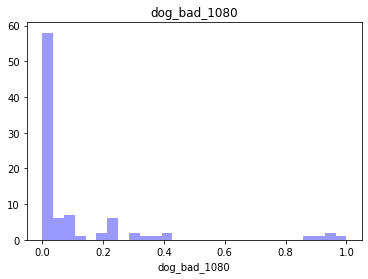

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


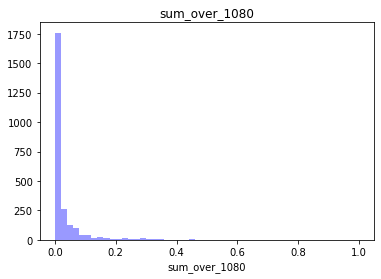

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


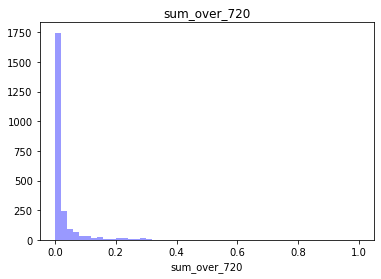

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


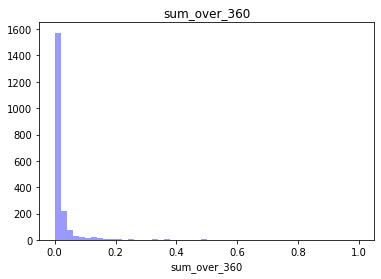

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


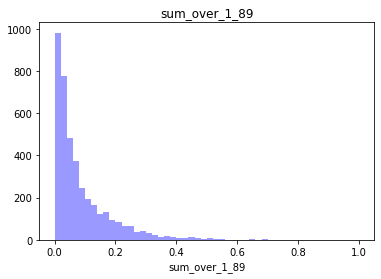

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


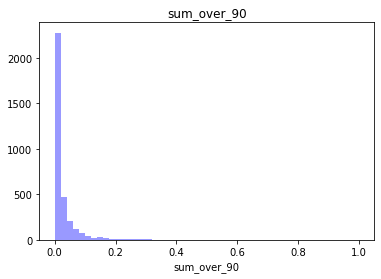

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


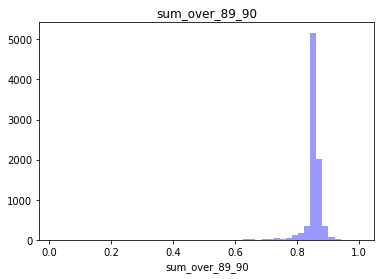

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


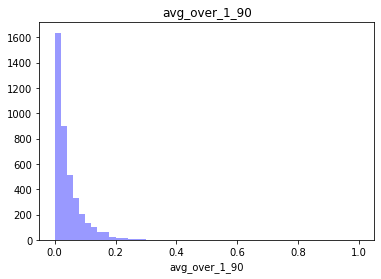

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


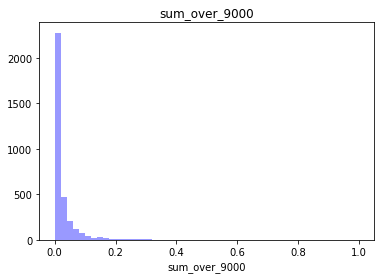

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


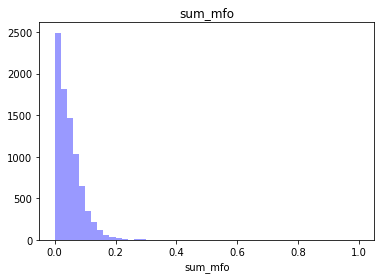

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


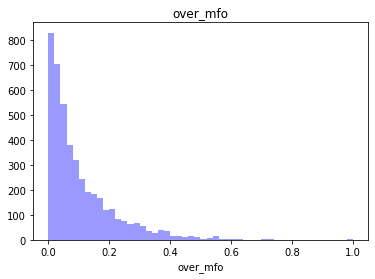

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


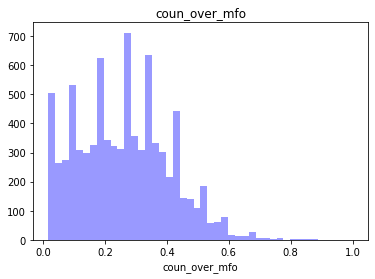

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


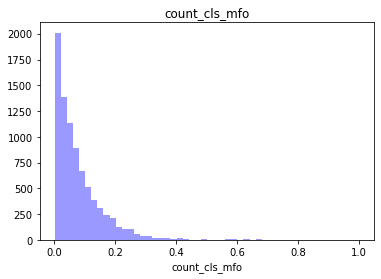

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


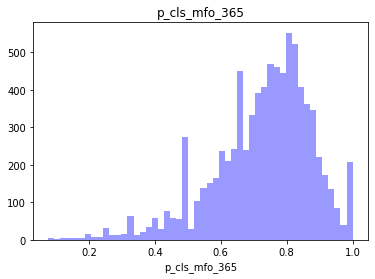

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


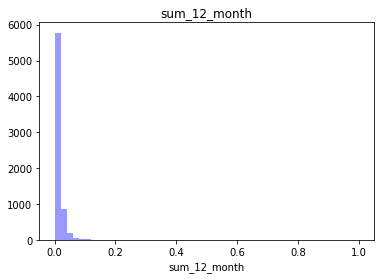

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


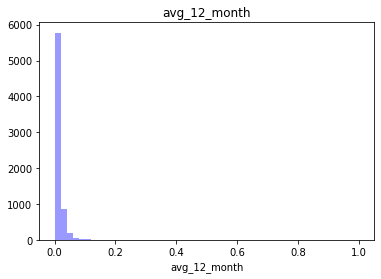

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


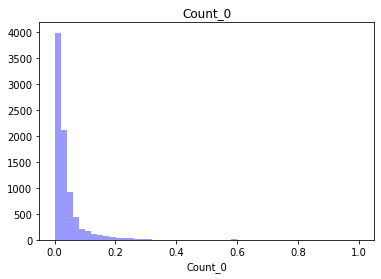

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


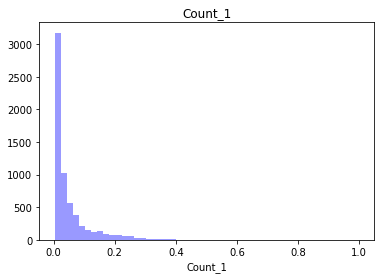

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


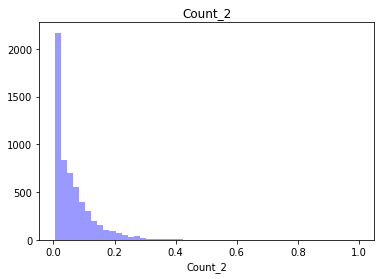

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


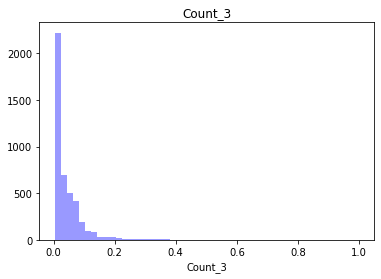

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


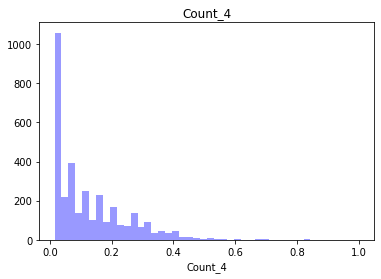

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


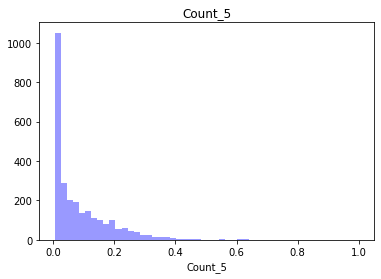

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


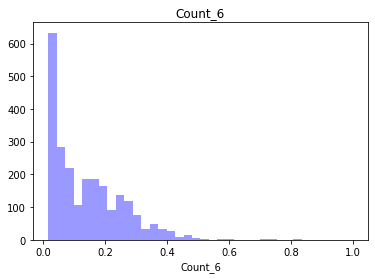

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


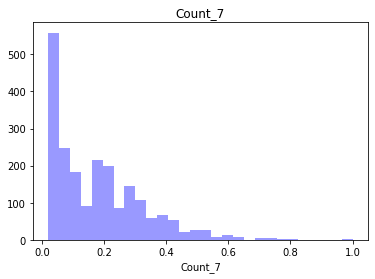

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


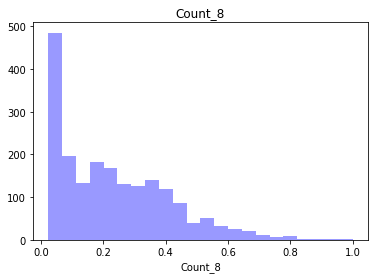

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


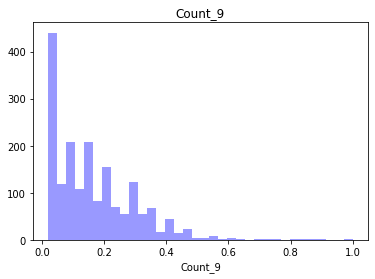

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


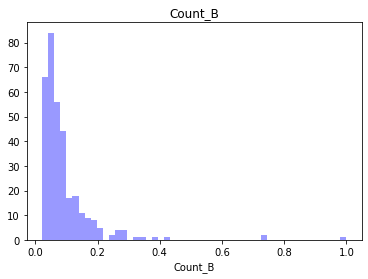

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


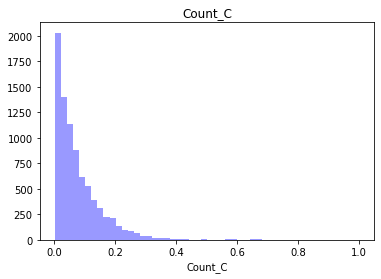

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


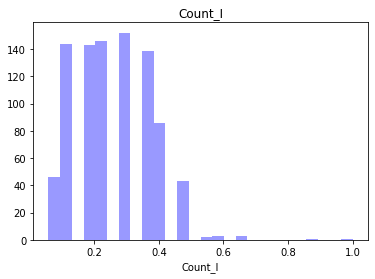

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


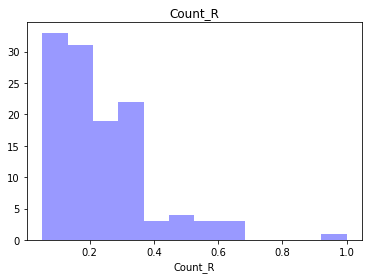

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


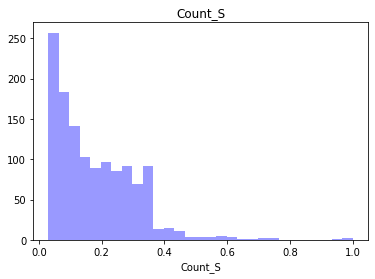

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


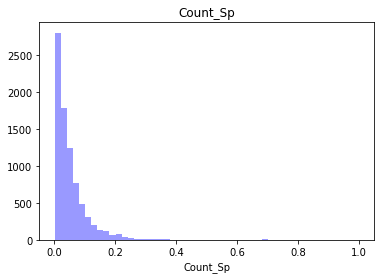

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


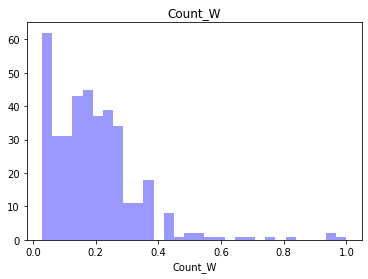

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


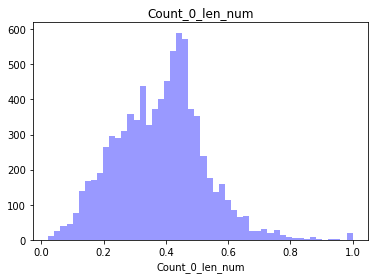

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


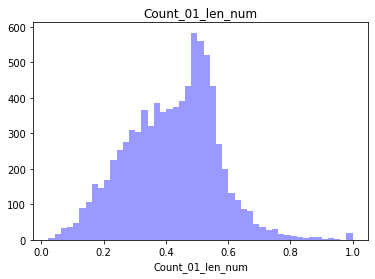

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


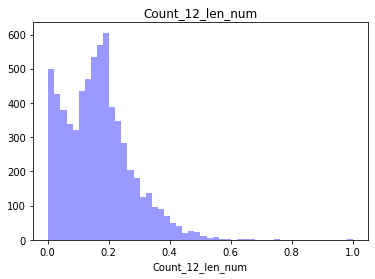

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


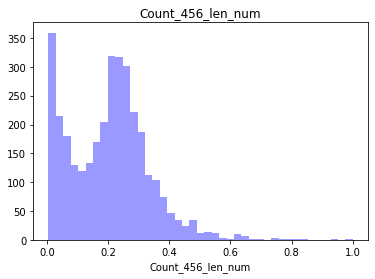

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


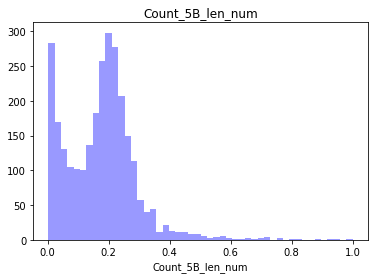

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


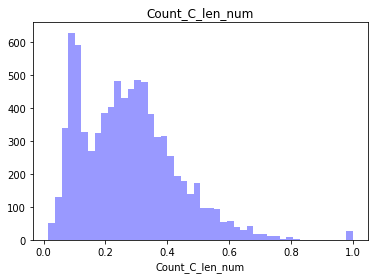

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


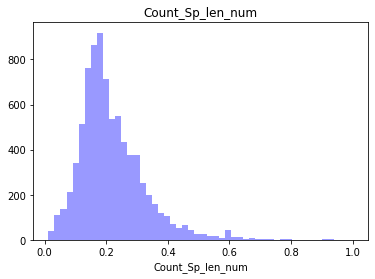

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


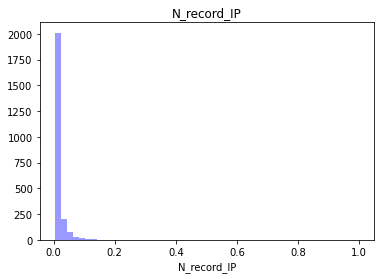

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


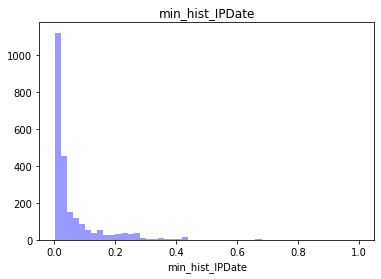

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


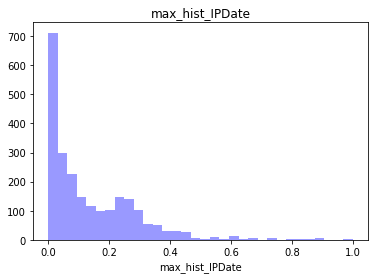

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


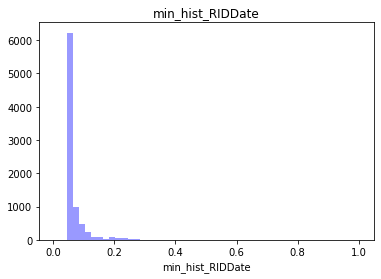

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


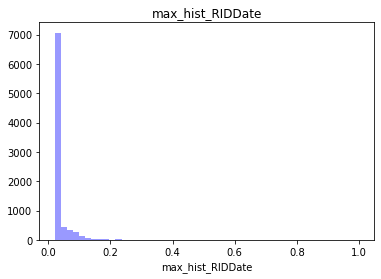

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


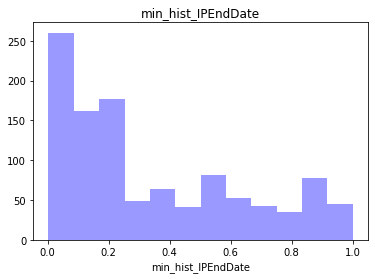

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


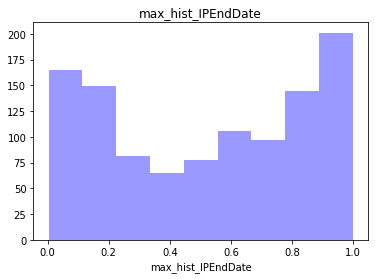

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


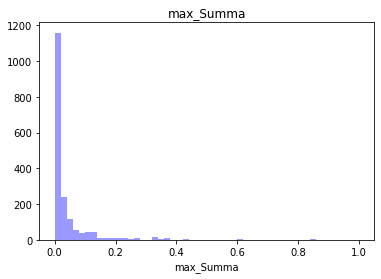

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


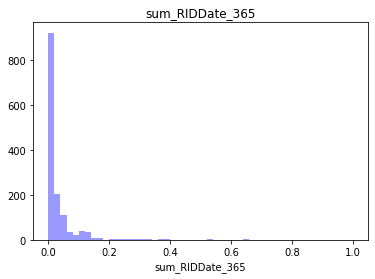

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


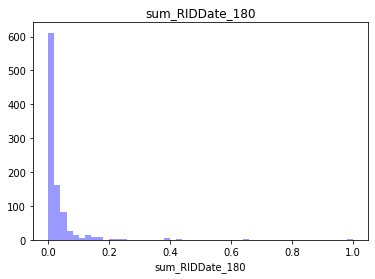

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


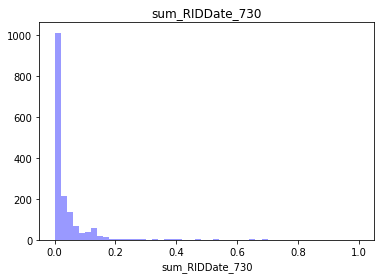

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


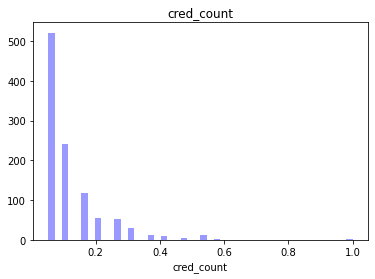

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


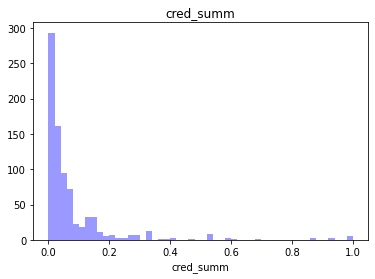

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


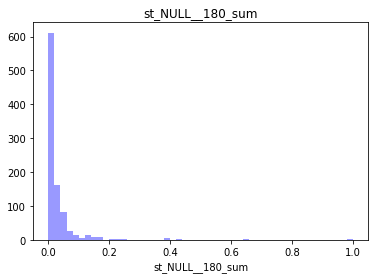

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


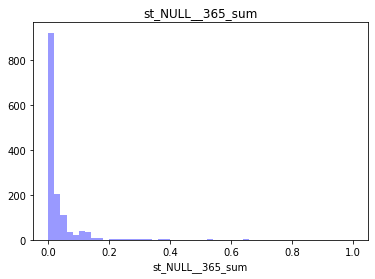

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


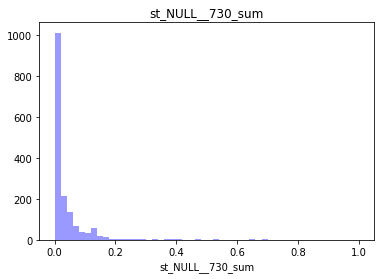

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


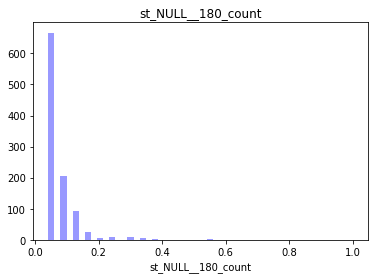

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


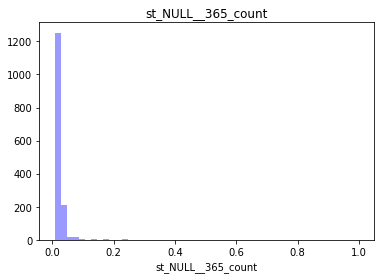

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


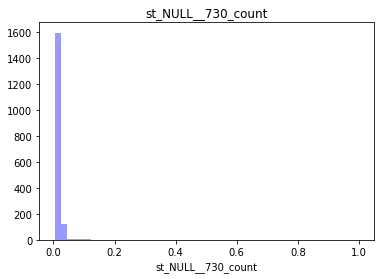

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


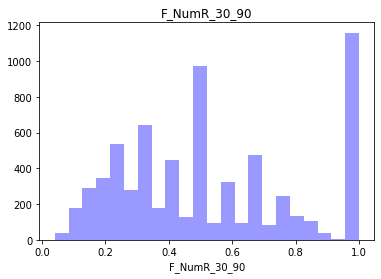

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


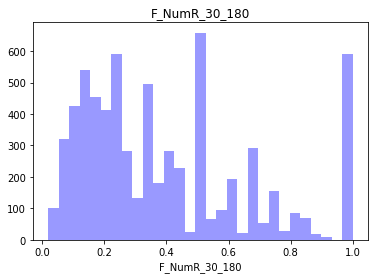

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


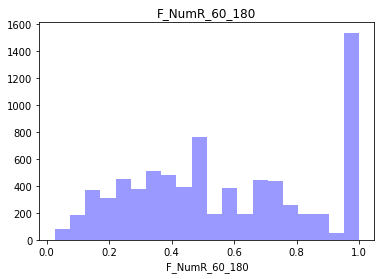

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


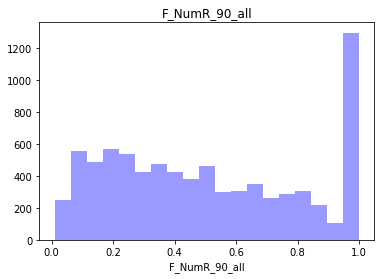

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


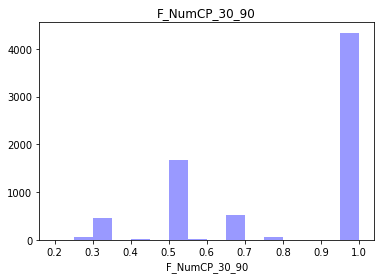

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


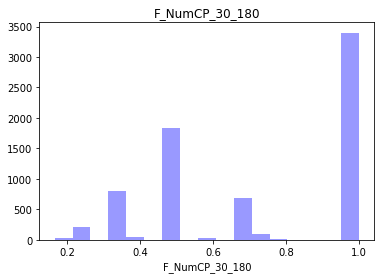

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


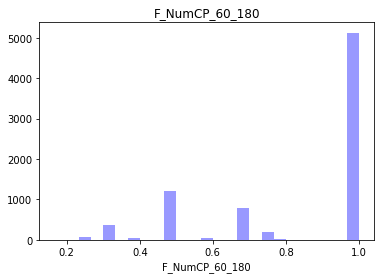

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


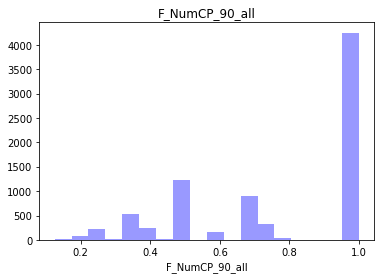

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


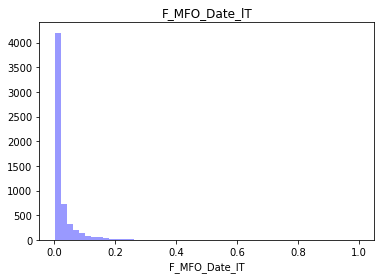

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


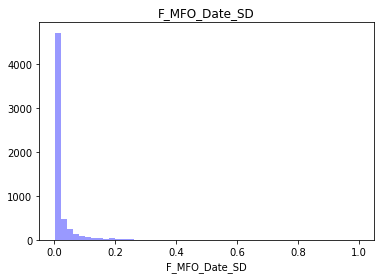

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


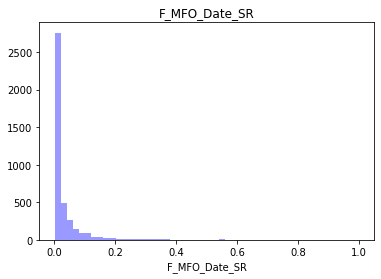

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


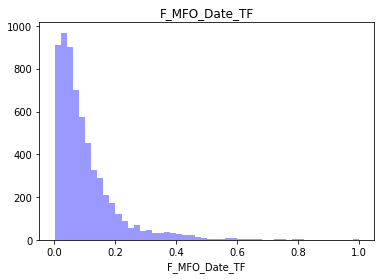

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


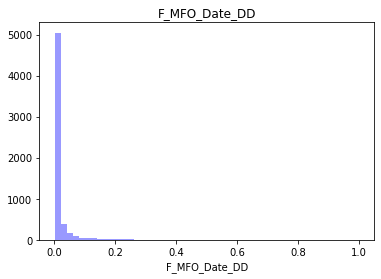

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


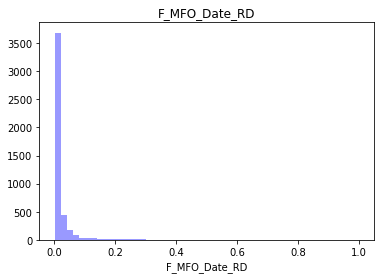

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


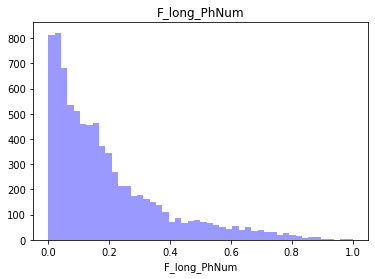

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


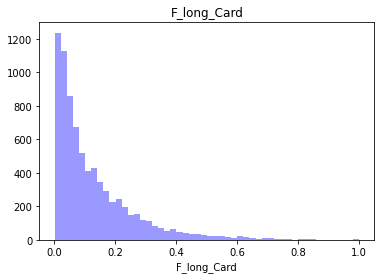

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


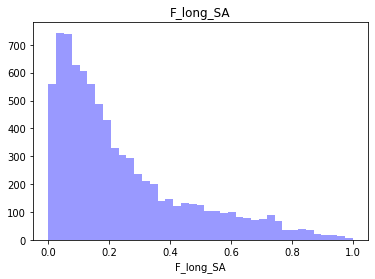

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


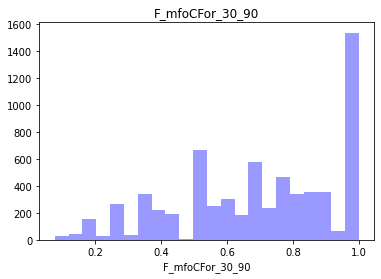

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


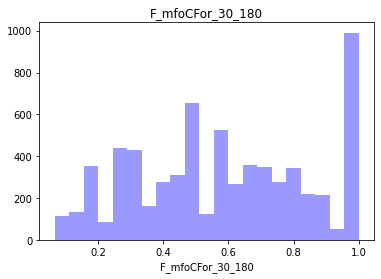

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


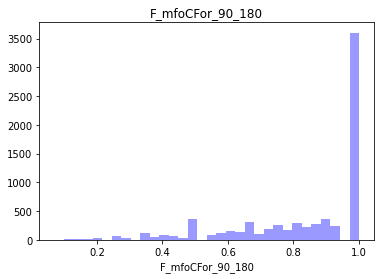

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


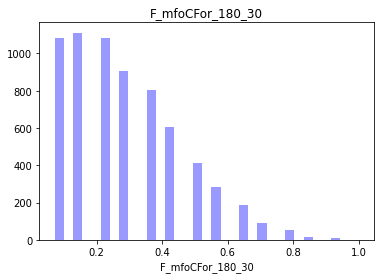

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


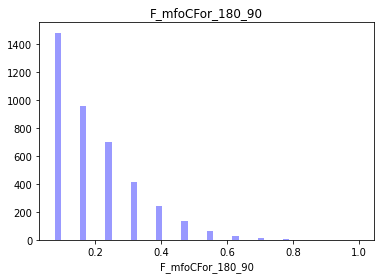

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


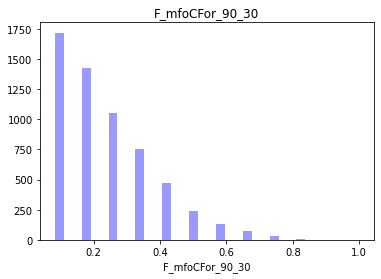

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


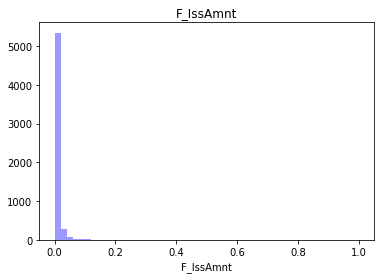

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


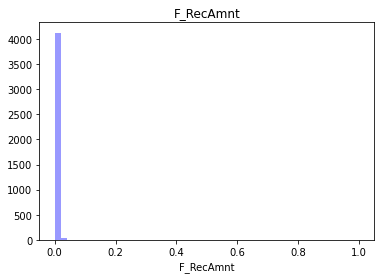

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


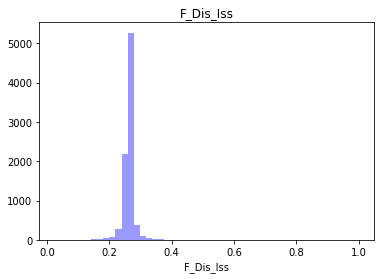

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


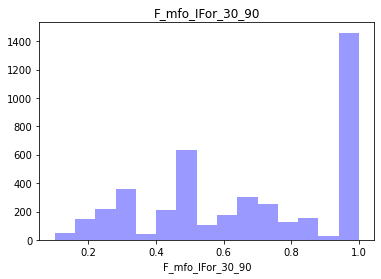

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


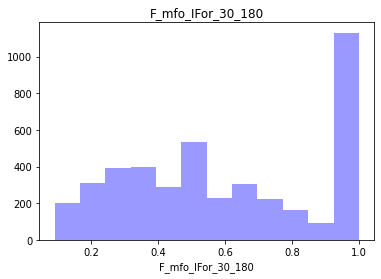

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


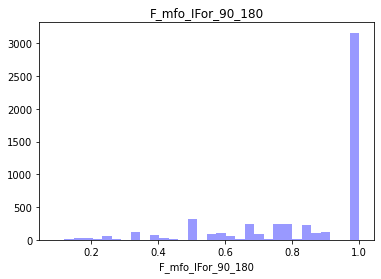

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


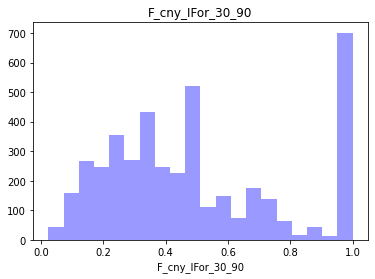

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


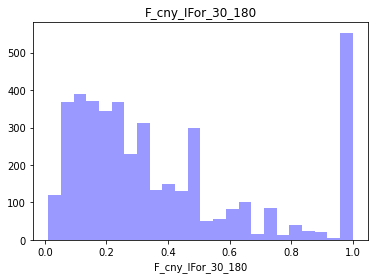

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


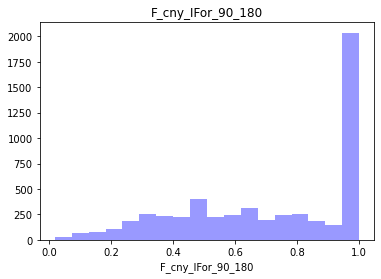

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


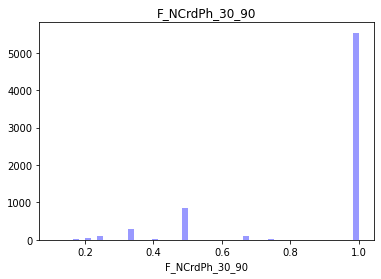

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


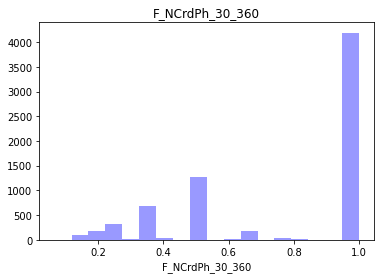

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


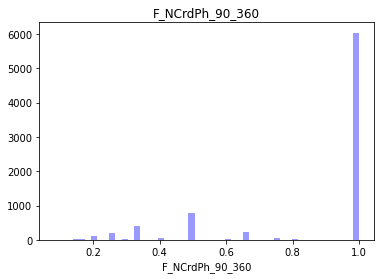

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


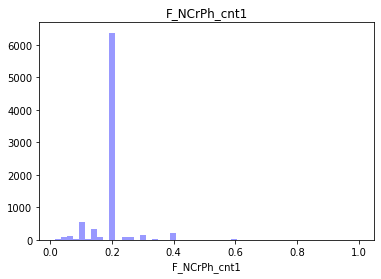

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


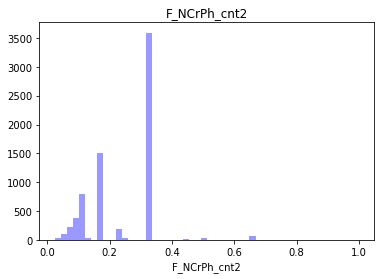

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


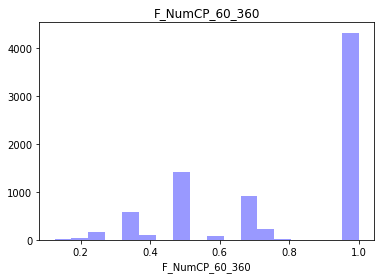

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


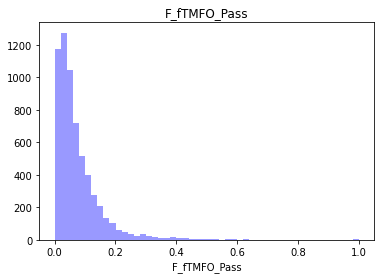

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


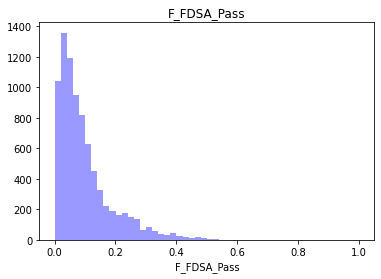

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


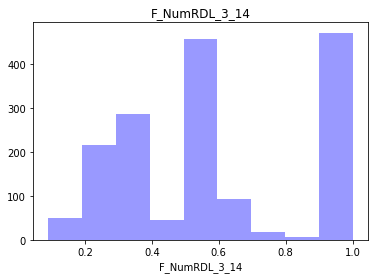

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


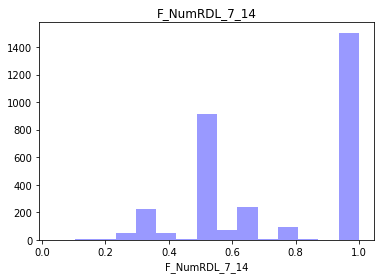

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


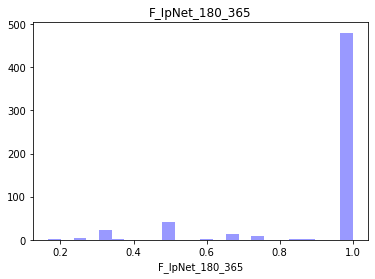

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


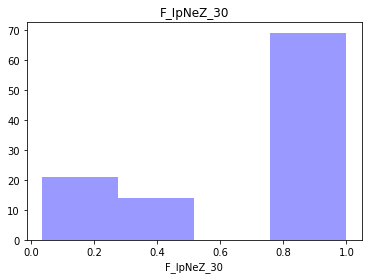

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


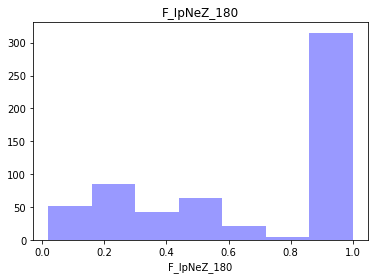

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


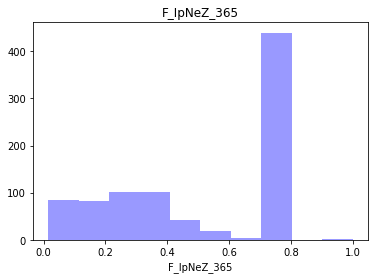

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


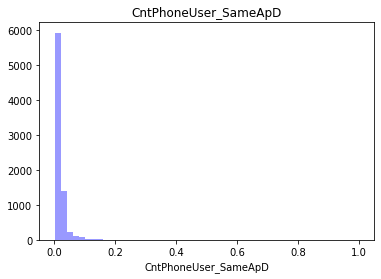

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


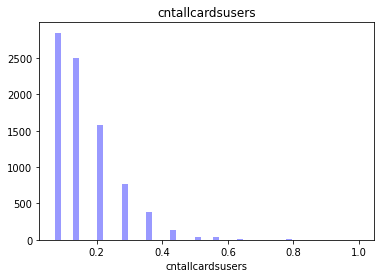

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


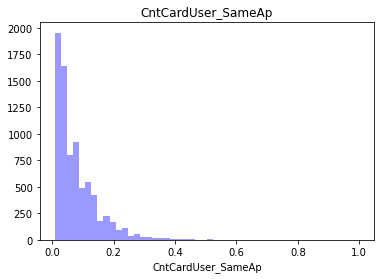

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


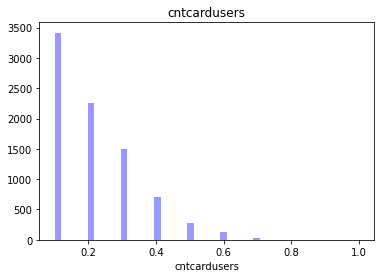

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


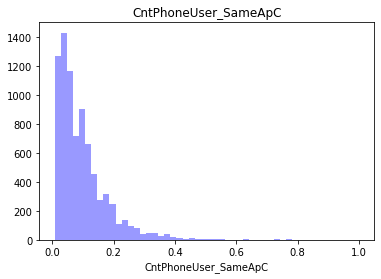

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


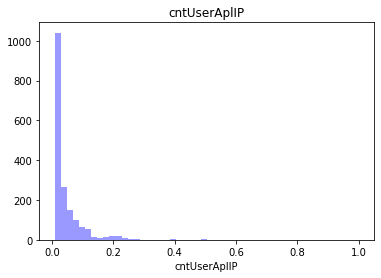

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


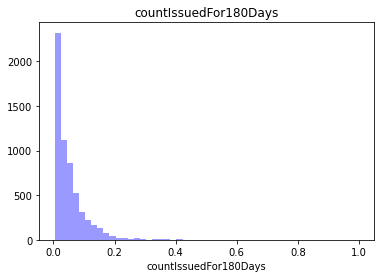

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


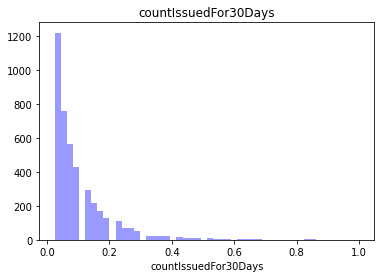

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


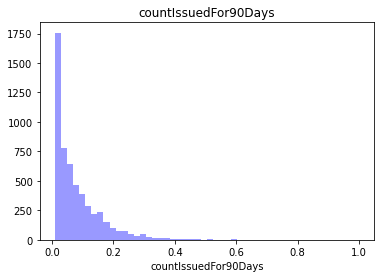

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


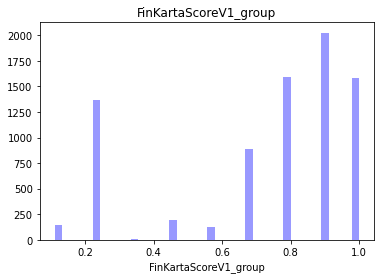

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


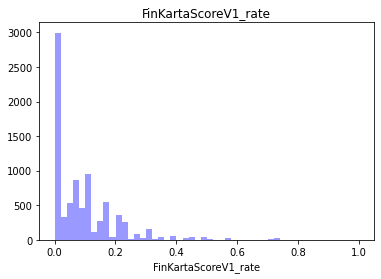

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


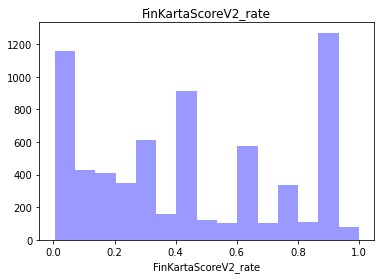

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


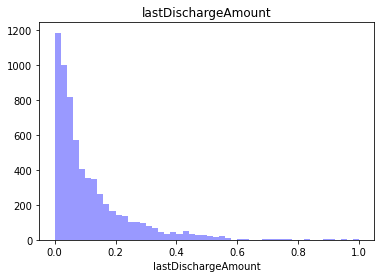

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


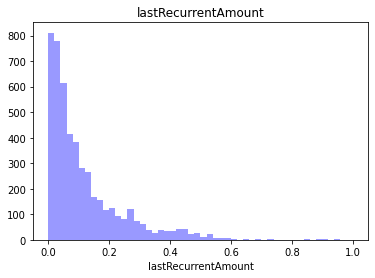

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


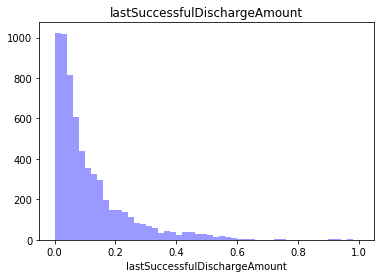

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


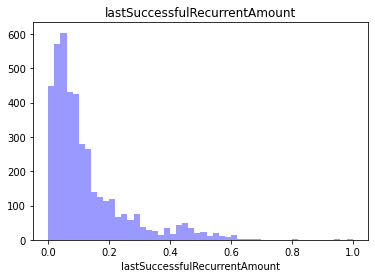

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


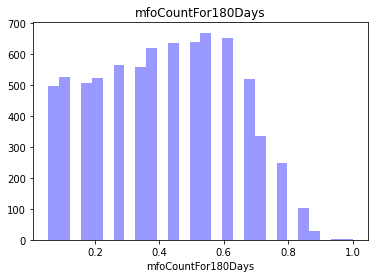

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


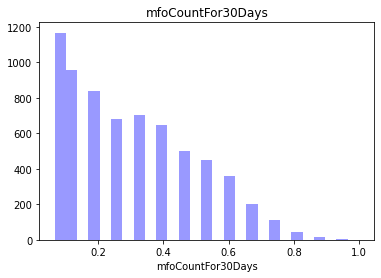

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


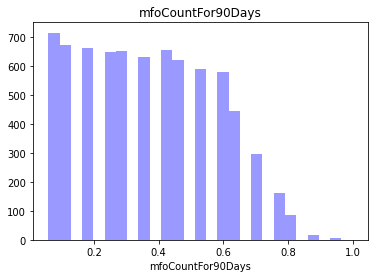

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


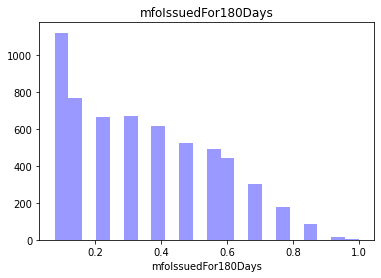

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


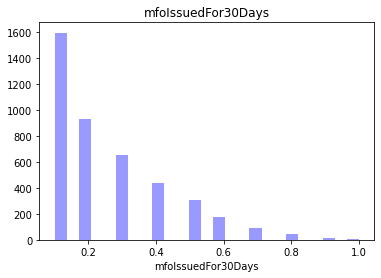

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


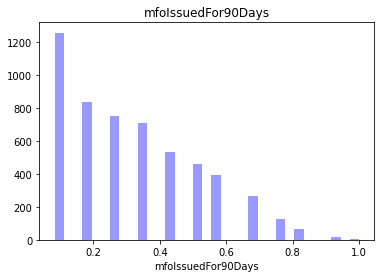

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


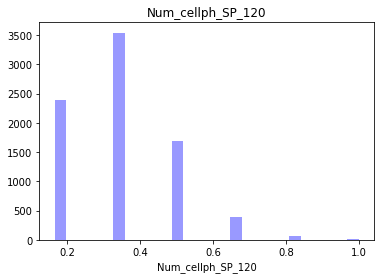

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


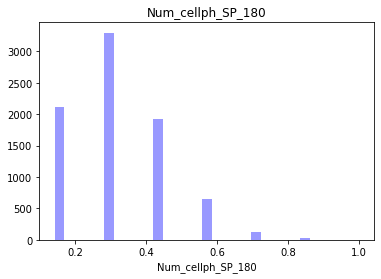

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


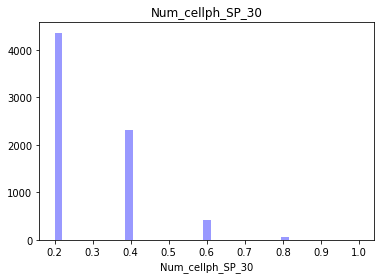

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


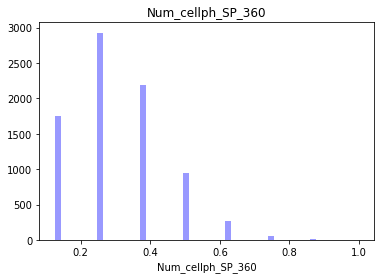

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


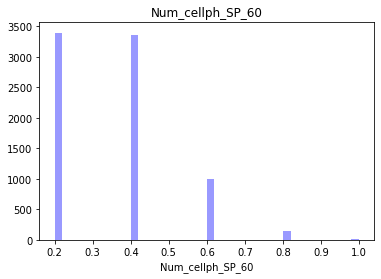

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


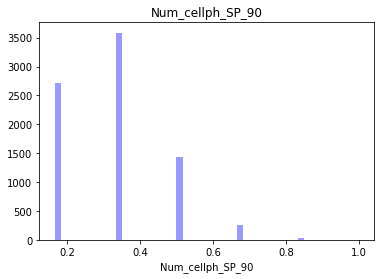

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


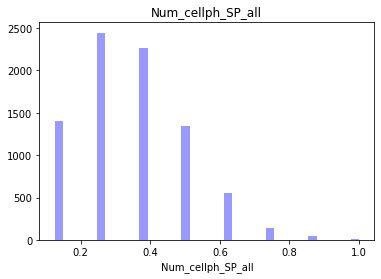

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


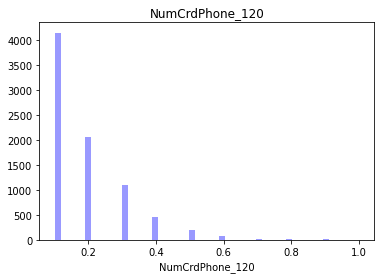

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


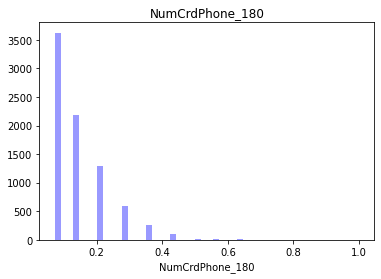

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


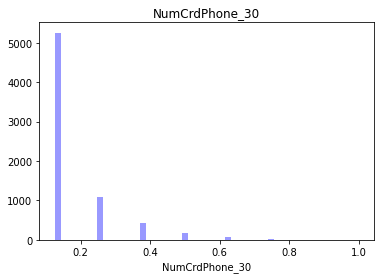

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


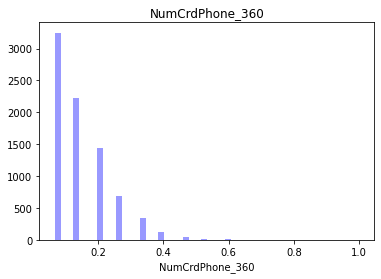

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


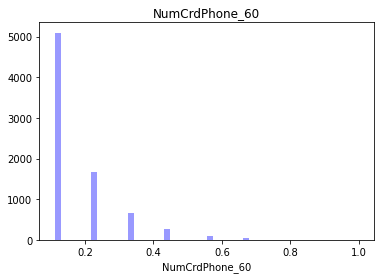

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


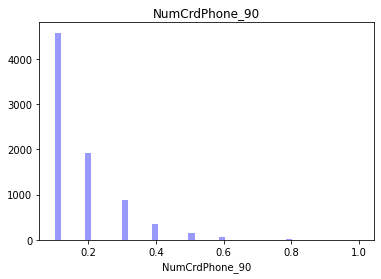

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


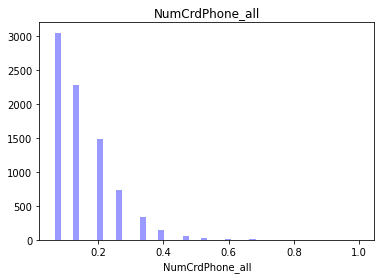

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


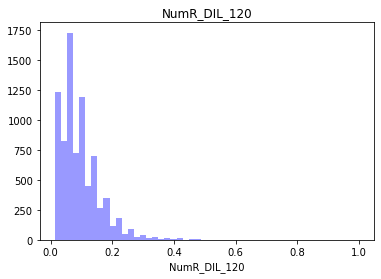

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


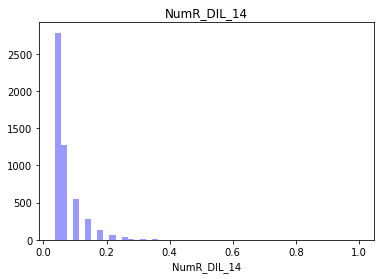

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


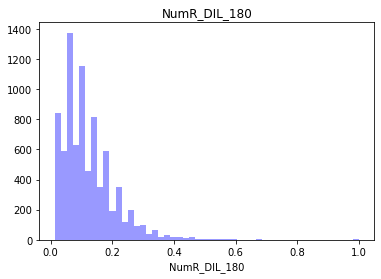

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


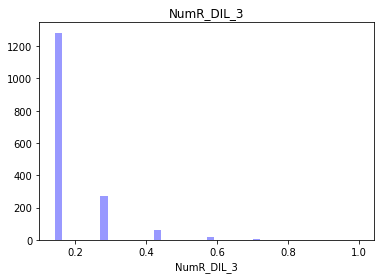

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


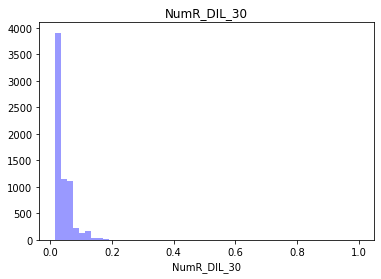

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


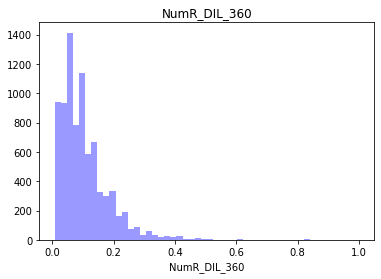

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


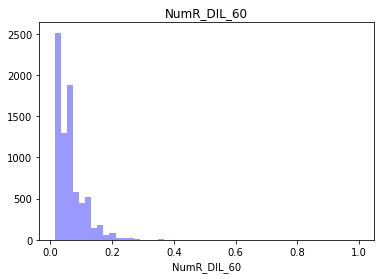

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


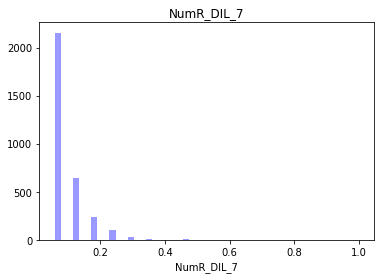

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


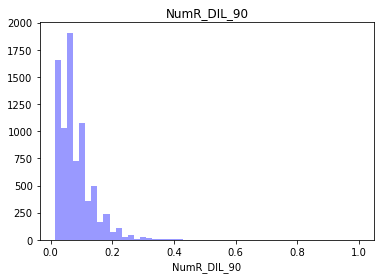

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


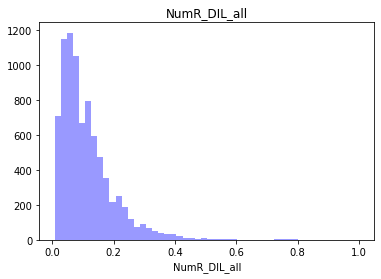

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


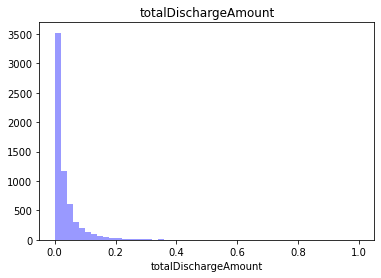

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


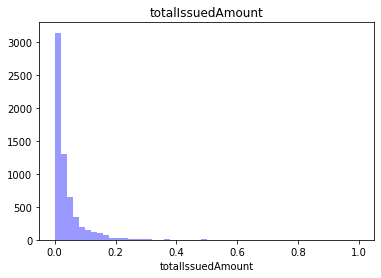

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


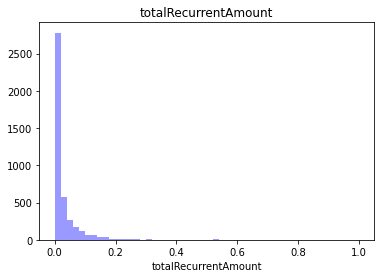

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


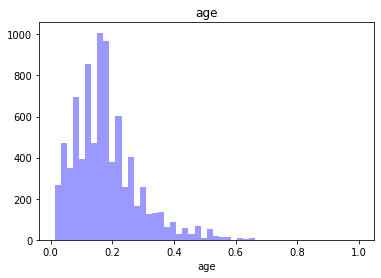

In [ ]:
#Применим MinMaxScaler, чтобы привести числовы епризнаки к одинаковому масштабу. Это важно для построения моделей машинного обучения.
log_num_cols = ['N_Loans', 'perc_amount', 'N_365', 'last_payment', 'N_90_365', 's_Amount', 's_Credit_befo_RD', 's_Credit_15',
 's_Credit_30', 's_Credit_90', 's_Credit_90_RD', 'Dola_RD_1', 'Dola_RD_2', 'Dola_RD_3', 'Dola_15_90', 'Dola_60_90', 'a_sum_Credit_700',
 'a_sum_Credit_365', 'a_sum_Credit_180', 'a_sum_Credit_90', 's_Amount_30', 's_Amount_60', 's_Amount_90', 's_Amount_180', 's_Amount_360',
 's_Amount_500', 'cred_hist_1', 'cred_hist_2', 'cred_hist_3', 'Cred_Deb_2', 'Cred_Deb_AmRe', 'Cred_Deb_AmRe_01', 'Cred_Deb_AmRe_1',
 'Cred_Deb_Deb', 'a_cnt_cred_45', 'a_cnt_cred_90', 'a_cnt_cred_135', 'a_cnt_cred_180', 'a_cnt_cred_700', 'a_cnt_cred_365',
 'miAmount_45', 'miAmount_90', 'miAmount_180', 'Amount_45', 'Amount_90', 'Amount_180', 'Amount_365', 'n_cr_1', 'n_cr_2',
 'n_cr_12', 'n_cr_3', 're_cred_1', 're_cred_2', 're_cred_3', 'persent_loan', 'cred_sum_1', 'cred_sum_2', 'cred_sum_3',
 'cred_sum_22', 'cred_sum_33', 'cred_dura_1', 'cred_dura_2', 'cred_dura_3', 'delay5_1', 'delay5_2', 'delay5_3', 'delay5_22',
 'delay5_33', 'delay30_1', 'delay30_2', 'delay30_3', 'delay60_1', 'delay60_2', 'delay60_3', 'delay90_1', 'delay90_2', 'delay90_3',
 'delay_more_1', 'delay_more_2', 'delay_more_3', 'delay5_30_365', 'delay5_30_60_365', 'cred_type_1', 'cred_type_2', 'cred_type_3',
 'partner_type_1', 'partner_type_2', 'partner_type_3', 'cred_repay_1', 'cred_repay_2', 'cred_repay_3', 'cred_activ_1',
 'cred_activ_2', 'cred_activ_3', 'all_act_cred_3', 'all_act_cred_1', 'all_act_cred_3_1', 'all_act_cred_2', 'all_act_3_1_d',
 'all_cred_rep_3', 'all_cred_rep_1', 'all_cred_rep_13', 'all_cred_rep_11', 'all_rep_cred_1', 'all_act_cred', 'all_act_cred_s',
 'test_1', 'sum_debt', 'sum_debt_1', 'sum_limit', 'sum_overdue', 'day_overdue', 'max_overdue', 'max_overdue_1',
 'max_overdue_2', 'max_overdue_3', 'prolong', 'ti_hour', 'ti_day', 'ti_week', 'ti_week_all', 'ti_month', 'ti_month_all', 'ti_quarter',
 'ti_year', 'cred_date_last', 'cred_date_last_1', 'cred_date_last_2', 'sum_debt_last', 'hist_days', 'hist_days_m', 'dog_bad',
 'dog_bad_360', 'dog_bad_1080', 'sum_over_1080', 'sum_over_720', 'sum_over_360', 'sum_over_1_89', 'sum_over_90', 'sum_over_89_90',
 'avg_over_1_90', 'sum_over_9000', 'sum_mfo', 'over_mfo', 'сoun_over_mfo', 'сount_cls_mfo', 'p_cls_mfo_365', 'sum_12_month',
 'avg_12_month', 'Count_0', 'Count_1', 'Count_2', 'Count_3', 'Count_4', 'Count_5', 'Count_6', 'Count_7', 'Count_8', 'Count_9',
 'Count_B', 'Count_C', 'Count_I', 'Count_R', 'Count_S', 'Count_Sp', 'Count_W', 'Count_0_len_num',
 'Count_01_len_num', 'Count_12_len_num', 'Count_456_len_num', 'Count_5B_len_num', 'Count_C_len_num', 'Count_Sp_len_num',
 'N_record_IP', 'min_hist_IPDate', 'max_hist_IPDate', 'min_hist_RIDDate', 'max_hist_RIDDate', 'min_hist_IPEndDate',
 'max_hist_IPEndDate', 'max_Summa', 'sum_RIDDate_365', 'sum_RIDDate_180', 'sum_RIDDate_730', 'cred_count', 'cred_summ',
 'st_NULL__180_sum', 'st_NULL__365_sum', 'st_NULL__730_sum', 'st_NULL__180_count', 'st_NULL__365_count', 'st_NULL__730_count',
 'F_NumR_30_90', 'F_NumR_30_180', 'F_NumR_60_180', 'F_NumR_90_all', 'F_NumCP_30_90', 'F_NumCP_30_180', 'F_NumCP_60_180',
 'F_NumCP_90_all', 'F_MFO_Date_lT', 'F_MFO_Date_SD', 'F_MFO_Date_SR', 'F_MFO_Date_TF', 'F_MFO_Date_DD', 'F_MFO_Date_RD',
 'F_long_PhNum', 'F_long_Card', 'F_long_SA', 'F_mfoCFor_30_90', 'F_mfoCFor_30_180', 'F_mfoCFor_90_180', 'F_mfoCFor_180_30',
 'F_mfoCFor_180_90', 'F_mfoCFor_90_30', 'F_IssAmnt', 'F_RecAmnt', 'F_Dis_Iss', 'F_mfo_IFor_30_90', 'F_mfo_IFor_30_180',
 'F_mfo_IFor_90_180', 'F_cny_IFor_30_90', 'F_cny_IFor_30_180', 'F_cny_IFor_90_180', 'F_NCrdPh_30_90', 'F_NCrdPh_30_360',
 'F_NCrdPh_90_360', 'F_NCrPh_cnt1', 'F_NCrPh_cnt2', 'F_NumCP_60_360', 'F_fTMFO_Pass', 'F_FDSA_Pass', 'F_NumRDL_3_14',
 'F_NumRDL_7_14', 'F_IpNet_180_365', 'F_IpNeZ_30', 'F_IpNeZ_180', 'F_IpNeZ_365', 'CntPhoneUser_SameApD', 'cntallcardsusers',
 'CntCardUser_SameAp', 'cntcardusers', 'CntPhoneUser_SameApC', 'cntUserAplIP', 'countIssuedFor180Days', 'countIssuedFor30Days',
 'countIssuedFor90Days', 'FinKartaScoreV1_group', 'FinKartaScoreV1_rate', 'FinKartaScoreV2_rate', 'lastDischargeAmount',
 'lastRecurrentAmount', 'lastSuccessfulDischargeAmount', 'lastSuccessfulRecurrentAmount', 'mfoCountFor180Days', 'mfoCountFor30Days',
 'mfoCountFor90Days', 'mfoIssuedFor180Days', 'mfoIssuedFor30Days', 'mfoIssuedFor90Days', 'Num_cellph_SP_120', 'Num_cellph_SP_180',
 'Num_cellph_SP_30', 'Num_cellph_SP_360', 'Num_cellph_SP_60', 'Num_cellph_SP_90', 'Num_cellph_SP_all', 'NumCrdPhone_120',
 'NumCrdPhone_180', 'NumCrdPhone_30', 'NumCrdPhone_360', 'NumCrdPhone_60', 'NumCrdPhone_90', 'NumCrdPhone_all', 'NumR_DIL_120',
 'NumR_DIL_14', 'NumR_DIL_180', 'NumR_DIL_3', 'NumR_DIL_30', 'NumR_DIL_360', 'NumR_DIL_60', 'NumR_DIL_7', 'NumR_DIL_90', 'NumR_DIL_all',
 'totalDischargeAmount', 'totalIssuedAmount', 'totalRecurrentAmount', 'age']

scaler = MinMaxScaler()
for column in log_num_cols:
    df[column] = scaler.fit_transform(df[[column]])[:,0]
    plt.figure()
    sns.distplot(df[column][df[column] > 0].dropna(), kde = False, rug=False, color='b')
    plt.title(column)
    plt.show()

In [ ]:
cat_cols = ['RegisterPhone', 'Register_Fact', 'EarlierCredits']
df = pd.get_dummies(df, columns=cat_cols, dummy_na=False)
#Поскольку в дальнейшем мы все признакм нормируем и они будут принмать значения от 0 до 1, заменим в признаке Gender занчения с 1 и 2 на 0 и 1:
df['Gender'] = df.apply(lambda x: 0 if (x.Gender==1) else 1, axis=1)

In [ ]:
df.head()

N_Loans  perc_amount     N_365  last_payment  N_90_365  s_Amount  \
0  0.000000     0.196424  0.047619      0.001610       1.0  0.003901   
1  0.050847     0.017405  0.190476      0.001610       1.0  0.008274   
2  0.016949     0.014557  0.095238      0.000322       1.0  0.003546   
3  0.000000     0.161392  0.047619      0.021578       0.0  0.003546   
4  0.000000     0.101266  0.047619      0.024155       0.0  0.000000   

   s_Credit_befo_RD  s_Credit_15  s_Credit_30  s_Credit_90  s_Credit_90_RD  \
0          0.000000     0.000000     0.000000     0.027601        0.007979   
1          0.009645     0.000000     0.000000     0.000000        0.008820   
2          0.005313     0.000000     0.000000     0.000000        0.004858   
3          0.002286     0.048127     0.032702     0.017030        0.007013   
4          0.000000     0.023973     0.016289     0.008483        0.002452   

   Dola_RD_1  Dola_RD_2  Dola_RD_3  Dola_15_90  Dola_60_90  a_sum_Credit_700  \
0        0.0        0.0        0.0         0.0         1.0          0.290415   
1        1.0        1.0        1.0         0.0         0.0          0.080255   
2        1.0        1.0        1.0         0.0         0.0          0.088412   
3        0.0        0.0        0.0         0.0         0.0          0.255262   
4        0.0        0.0        0.0         0.0         0.0          0.089257   

   a_sum_Credit_365  a_sum_Credit_180  a_sum_Credit_90  s_Amount_30  \
0          0.454483          0.542689         0.615016     0.000000   
1          0.125595          0.149971         0.169958     0.024691   
2          0.138360          0.165213         0.187232     0.061728   
3          0.399471          0.477001         0.000000     0.000000   
4          0.139683          0.166792         0.000000     0.000000   

   s_Amount_60  s_Amount_90  s_Amount_180  s_Amount_360  s_Amount_500  \
0     0.000000     0.046491        0.0265      0.016012      0.011373   
1     0.107143     0.078947        0.0450      0.027190      0.019313   
2     0.059524     0.043860        0.0250      0.015106      0.010730   
3     0.000000     0.000000        0.0250      0.015106      0.010730   
4     0.000000     0.000000        0.0100      0.006042      0.004292   

   cred_hist_1  cred_hist_2  cred_hist_3  Cred_Deb_2  Cred_Deb_AmRe  \
0     0.021567     0.021907     0.021907    0.017339       0.089749   
1     0.014589     0.001611     0.001611    0.005476       0.071483   
2     0.002854     0.002255     0.002255    0.005278       0.071330   
3     0.031716     0.032216     0.032216    0.010160       0.080525   
4     0.033619     0.034149     0.034149    0.003553       0.073138   

   Cred_Deb_AmRe_01  Cred_Deb_AmRe_1  Cred_Deb_Deb  a_cnt_cred_45  \
0          0.145106         0.251182      0.389592            0.0   
1          0.145106         0.148342      0.253606            0.3   
2          0.145106         0.147480      0.251442            0.2   
3          0.145106         0.199253      0.362981            0.0   
4          0.145106         0.157658      0.317308            0.0   

   a_cnt_cred_90  a_cnt_cred_135  a_cnt_cred_180  a_cnt_cred_700  \
0       0.076923        0.071429        0.071429        0.028571   
1       0.307692        0.285714        0.285714        0.114286   
2       0.153846        0.142857        0.142857        0.057143   
3       0.000000        0.071429        0.071429        0.028571   
4       0.000000        0.071429        0.071429        0.028571   

   a_cnt_cred_365  miAmount_45  miAmount_90  miAmount_180  Amount_45  \
0        0.047619     0.000000     0.176667      0.176667   0.000000   
1        0.190476     0.022496     0.019047      0.019047   0.030183   
2        0.095238     0.039370     0.033333      0.033333   0.052817   
3        0.047619     0.000000     0.000000      0.111113   0.000000   
4        0.047619     0.000000     0.000000      0.044447   0.000000   

   Amount_90  Amount_180  Amount_365    n_cr_1    n_cr_2   n_cr_12  ...

Разделим датасет на тестовые и тренировочные данные. Обучение и тестирование модели будет производиться на тренировочных данных. Предсказание модели будем делать на тестовой части.

In [ ]:
X = df.drop('Default',axis=1)
y = df['Default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Проверим соотношение клаасов целевой переменной в тренировочной и тестовой выборках:

In [ ]:
y_train.value_counts()

0    4527
1    2241
Name: Default, dtype: int64

In [ ]:
y_test.value_counts()

0    1132
1     561
Name: Default, dtype: int64

Соотношение классов в обучающей и тестовой выборках приблизительно одинаковое.

##3.2 Модели:

##3.2.1 MODEL 1. Логистическая регрессия:
Параметры по умолчанию

In [ ]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

#Предсказываем значения целевой переменной и вероятность 
y_pred = model.predict(X_test)
probs = model.predict_proba(X_test)[:,1]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
# Оценка качества модели
metrics_total(y_test, y_pred, probs)

Metrics       Result  \
P                Positive  1132.000000   
N                Negative   561.000000   
TP          True positive  1005.000000   
TN          True Negative   185.000000   
FP         False Positive   376.000000   
FN         False Negative   127.000000   
Accuracy         Accuracy    70.289427   
Precision       Precision    59.294872   
Recall             Recall    32.976827   
F1-score           F-мера    42.382589   
ROC_AUC           ROC_AUC    71.595082   
Gini                 Gini    43.190164   

                                        Description  
P                                       БЕЗ Дефолта  
N                                            Дефолт  
TP                             Истинно НЕ дефолтные  
TN                                Истинно дефолтные  
FP                               Ложно НЕ дефолтные  
FN                                  Ложно дефолтные  
Accuracy        Accuracy=(TP+TN)/(TP+TN+FP+FN)*100%  
Precision                Точность = TP/(TP+FP)*100%  
Recall                    Полнота = TP/(TP+FN)*100%  
F1-score   Среднее гармоническое Precision и Recall  
ROC_AUC                                     ROC-AUC  
Gini                               Коэффициент Gini

In [ ]:
#Создадим датафрейм , в котором будем собирать для сравнения данные по всем моделям
lst_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC_AUC', 'Gini']
df_comp = pd.DataFrame(lst_metrics)
df_comp.columns = ['Metrics']
df_comp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Metrics  6 non-null      object
dtypes: object(1)
memory usage: 176.0+ bytes


In [ ]:
df_comp = cumulated_res(df_comp, 'log_reg', y_test, y_pred, probs)
df_comp

Metrics    log_reg
0   Accuracy  70.289427
1  Precision  59.294872
2     Recall  32.976827
3   F1-score  42.382589
4    ROC_AUC  71.595082
5       Gini  43.190164

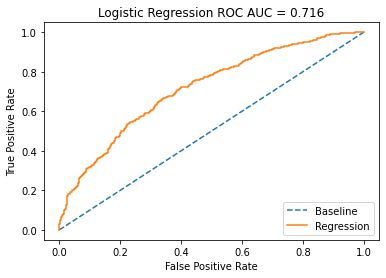

In [ ]:
#Кривая ROC_AUC
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
# [0, 1] чтобы график был в пространстве от 0 до 1, по типу диагонали
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

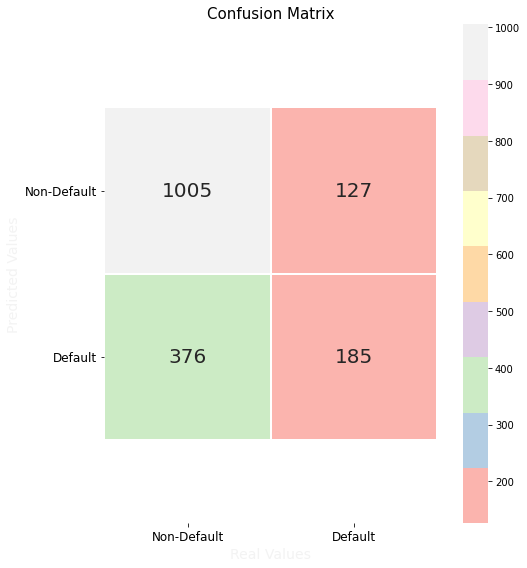

In [ ]:
#Посмотрим, какое количество клиентов, вернувших кредит и потерпевших дефолт наша модель показала не правильно: 
conf_matr(y_test, y_pred)

Модель показала достаточно хороший результат, критерий Gini 43%, значит она достаточно хорошо разделяет тех, кто вернет кредит и кто нет. Логистическую регрессию использую многие банки, т.к. им важна легкая интерпретируемость модели.

##3.2.2 MODEL 2. XGBoost

Попробуем взять модель XGBoost с параметрами по умолчанию:



In [ ]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

#Предсказываем значения целевой переменной и вероятность 
y_pred = model.predict(X_test)
probs = model.predict_proba(X_test)[:,1]

In [ ]:
# Оценка качества модели
metrics_total(y_test, y_pred, probs)

Metrics       Result  \
P                Positive  1132.000000   
N                Negative   561.000000   
TP          True positive  1021.000000   
TN          True Negative   180.000000   
FP         False Positive   381.000000   
FN         False Negative   111.000000   
Accuracy         Accuracy    70.939161   
Precision       Precision    61.855670   
Recall             Recall    32.085561   
F1-score           F-мера    42.253521   
ROC_AUC           ROC_AUC    72.961899   
Gini                 Gini    45.923798   

                                        Description  
P                                       БЕЗ Дефолта  
N                                            Дефолт  
TP                             Истинно НЕ дефолтные  
TN                                Истинно дефолтные  
FP                               Ложно НЕ дефолтные  
FN                                  Ложно дефолтные  
Accuracy        Accuracy=(TP+TN)/(TP+TN+FP+FN)*100%  
Precision                Точность = TP/(TP+FP)*100%  
Recall                    Полнота = TP/(TP+FN)*100%  
F1-score   Среднее гармоническое Precision и Recall  
ROC_AUC                                     ROC-AUC  
Gini                               Коэффициент Gini

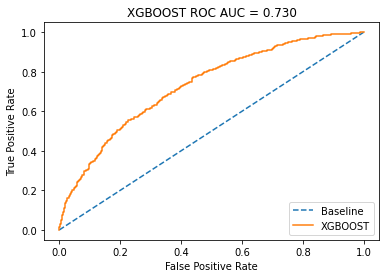

In [ ]:
#Кривая ROC_AUC
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'XGBOOST')
plt.title('XGBOOST ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

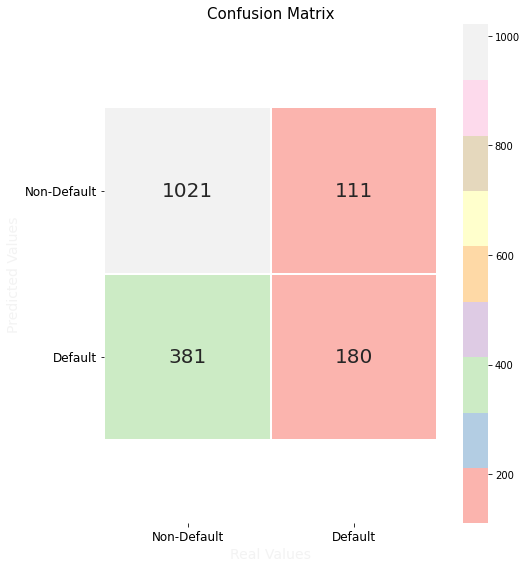

In [ ]:
#Посмотрим, какое количество клиентов, вернувших кредит и потерпевших дефолт наша модель показала не правильно: 
conf_matr(y_test, y_pred)

In [ ]:
df_comp = cumulated_res(df_comp, 'XGB', y_test, y_pred, probs)
df_comp

Metrics    log_reg        XGB
0   Accuracy  70.289427  70.939161
1  Precision  59.294872  61.855670
2     Recall  32.976827  32.085561
3   F1-score  42.382589  42.253521
4    ROC_AUC  71.595082  72.961899
5       Gini  43.190164  45.923798

Модель XGBoost показала лучший результат по accuracy, точности, ROC_AUC и Gini, но у нее немного ниже полнота и F1-мера. Она лучше разделяет дефолты и не дефолты. У нее больше ошибка 1 рода, но меньше ошибка 2 рода по сравнению с логистической регрессией.

##3.2.3 MODEL 3. CATBOOST

In [ ]:
model = CatBoostClassifier(iterations=100, random_seed=42)
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=500,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.138367
0:	learn: 0.6686403	test: 0.6689153	best: 0.6689153 (0)	total: 92ms	remaining: 9.11s
99:	learn: 0.4339914	test: 0.5672326	best: 0.5636168 (50)	total: 5.05s	remaining: 0us

bestTest = 0.5636168117
bestIteration = 50

Shrink model to first 51 iterations.


In [ ]:
#Предсказываем значения целевой переменной и вероятность 
y_pred = model.predict(X_test)
probs = model.predict_proba(X_test)[:,1]

In [ ]:
# Оценка качества модели
metrics_total(y_test, y_pred, probs)

Metrics       Result  \
P                Positive  1132.000000   
N                Negative   561.000000   
TP          True positive  1024.000000   
TN          True Negative   158.000000   
FP         False Positive   403.000000   
FN         False Negative   108.000000   
Accuracy         Accuracy    69.816893   
Precision       Precision    59.398496   
Recall             Recall    28.163993   
F1-score           F-мера    38.210399   
ROC_AUC           ROC_AUC    72.333762   
Gini                 Gini    44.667523   

                                        Description  
P                                       БЕЗ Дефолта  
N                                            Дефолт  
TP                             Истинно НЕ дефолтные  
TN                                Истинно дефолтные  
FP                               Ложно НЕ дефолтные  
FN                                  Ложно дефолтные  
Accuracy        Accuracy=(TP+TN)/(TP+TN+FP+FN)*100%  
Precision                Точность = TP/(TP+FP)*100%  
Recall                    Полнота = TP/(TP+FN)*100%  
F1-score   Среднее гармоническое Precision и Recall  
ROC_AUC                                     ROC-AUC  
Gini                               Коэффициент Gini

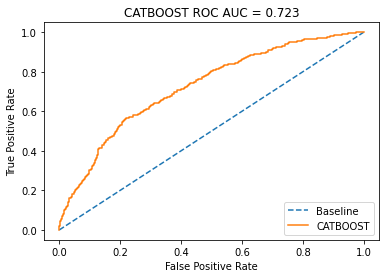

In [ ]:
#Кривая ROC_AUC
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'CATBOOST')
plt.title('CATBOOST ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

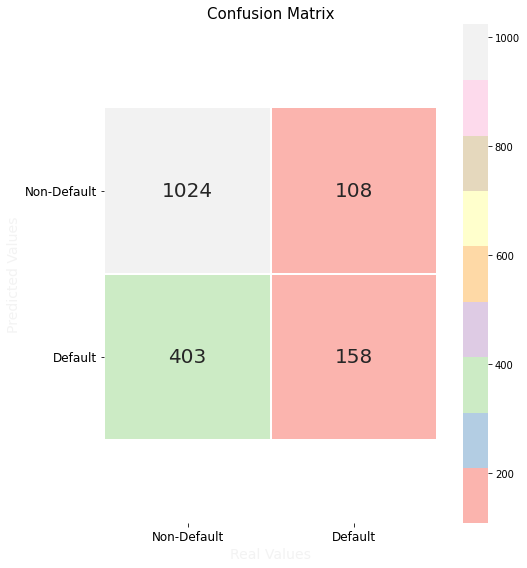

In [ ]:
#Confusion matrix
conf_matr(y_test, y_pred)

In [ ]:
df_comp = cumulated_res(df_comp, 'CatB', y_test, y_pred, probs)
df_comp

Metrics    log_reg        XGB       CatB
0   Accuracy  70.289427  70.939161  69.816893
1  Precision  59.294872  61.855670  59.398496
2     Recall  32.976827  32.085561  28.163993
3   F1-score  42.382589  42.253521  38.210399
4    ROC_AUC  71.595082  72.961899  72.333762
5       Gini  43.190164  45.923798  44.667523

CatBoost на параметрах по умолчанию показала результат хуже, чем логистическая регрессия. У нее неплохой коэффициент Gini, но достаточно большая по сравнению с другими моделями ошибка второго рода. Это плохо, т.к. может привести к упущенной прибыли финансовой организации.

Лучше всего для данной задачи себя показала модель XGboost - у нее самый высокий коэффициент Gini, значит она хорошо отделяет клиентов, которые вернут займ, от тех, у кого вероятность дефолта. Также у нее хороший показатель F1 score.

##3.3 Подбор признаков и гиперпараметров для модели XGBoost:

Как мы видели по матрице коррреляций, у нас достаточно много скоррелированных признаков, которые могут мешать обучению модели. Оставим для обучения только не коррелирующие между собой признаки:

In [ ]:
#Уберем скоррелированные признаки
df_for_model1 = df[['perc_amount', 'last_payment', 's_Amount', 's_Credit_90', 'Dola_RD_3', 'Dola_60_90', 'a_sum_Credit_700',
 's_Amount_500', 'cred_hist_1', 'cred_hist_2', 'Cred_Deb_2', 'Cred_Deb_AmRe_01', 'Cred_Deb_AmRe_1',
 'Cred_Deb_Deb', 'a_cnt_cred_365',
 'miAmount_180', 'Amount_365', 
 'n_cr_12', 're_cred_3', 'persent_loan', 'cred_sum_3',
 'cred_dura_3',  'delay30_3', 'delay90_3',
 'delay_more_3','delay5_30_60_365', 'cred_type_3',
 'partner_type_1', 'partner_type_3', 'cred_repay_3', 
 'all_act_cred_1', 'all_act_cred_3_1',  'all_act_3_1_d',
 'all_cred_rep_1',  'all_cred_rep_11', 'all_rep_cred_1', 'all_act_cred_s', 'sum_debt', 
 'sum_limit', 'sum_overdue', 'day_overdue', 'max_overdue',  'max_overdue_3',
 'prolong', 'ti_hour', 'ti_day', 'ti_week_all', 'ti_month_all', 'ti_quarter',
 'ti_year', 'cred_date_last', 'cred_date_last_1', 'cred_date_last_2', 'sum_debt_last', 'hist_days', 'hist_days_m', 'dog_bad',
 'dog_bad_360', 'dog_bad_1080', 'sum_over_1080', 'sum_over_360', 'sum_over_1_89', 'sum_over_89_90',
 'avg_over_1_90',  'sum_mfo', 'over_mfo', 'сoun_over_mfo', 'сount_cls_mfo', 'p_cls_mfo_365', 'sum_12_month',
 'Count_9',  'Count_B', 'Count_C', 'Count_I', 'Count_R', 'Count_S', 'Count_W', 'Count_0_len_num',
 'Count_12_len_num', 'Count_5B_len_num', 'Count_C_len_num', 'Count_Sp_len_num',
 'N_record_IP', 'min_hist_IPDate', 'max_hist_IPDate',  'max_Summa',  'st_NULL__365_sum',  'st_NULL__365_count',
 'F_NumR_60_180', 'F_NumR_90_all', 'F_NumCP_30_180', 'F_NumCP_60_180',
 'F_NumCP_90_all', 'F_MFO_Date_lT', 'F_MFO_Date_SR', 'F_MFO_Date_TF', 'F_MFO_Date_DD', 'F_MFO_Date_RD',
 'F_long_PhNum', 'F_long_Card', 'F_long_SA', 'F_mfoCFor_30_180', 'F_mfoCFor_90_180', 
 'F_mfoCFor_180_90', 'F_mfoCFor_90_30', 'F_IssAmnt', 'F_RecAmnt', 'F_Dis_Iss',  'F_mfo_IFor_30_180',
 'F_mfo_IFor_90_180',  'F_cny_IFor_30_180', 'F_cny_IFor_90_180', 'F_NCrdPh_30_90', 'F_NCrdPh_30_360',
 'F_NCrdPh_90_360', 'F_NCrPh_cnt1', 'F_NCrPh_cnt2', 'F_NumCP_60_360', 'F_fTMFO_Pass', 'F_FDSA_Pass', 'F_NumRDL_3_14',
 'F_NumRDL_7_14', 'F_IpNet_180_365',  'F_IpNeZ_365', 'CntPhoneUser_SameApD', 'cntallcardsusers',
 'CntCardUser_SameAp', 'cntcardusers', 'CntPhoneUser_SameApC', 'cntUserAplIP', 'countIssuedFor180Days',  'FinKartaScoreV1_group', 'FinKartaScoreV1_rate', 'FinKartaScoreV2_rate', 'lastDischargeAmount',
 'lastRecurrentAmount', 'lastSuccessfulDischargeAmount', 'lastSuccessfulRecurrentAmount', 'mfoCountFor180Days', 
 'mfoIssuedFor90Days', 'Num_cellph_SP_120', 'Num_cellph_SP_180',
 'Num_cellph_SP_360',  'Num_cellph_SP_all', 
 'NumCrdPhone_180', 'NumCrdPhone_30', 'NumCrdPhone_360', 'NumCrdPhone_60', 'NumCrdPhone_90', 'NumCrdPhone_all', 'NumR_DIL_120',
 'NumR_DIL_14', 'NumR_DIL_180', 'NumR_DIL_3', 'NumR_DIL_30', 'NumR_DIL_360', 'NumR_DIL_60', 'NumR_DIL_7', 'NumR_DIL_90',
 'NumR_DIL_all', 'totalDischargeAmount', 'Gender', 'RegisterPhone_0', 'RegisterPhone_1', 'Register_Fact_0', 'Register_Fact_1', 
 'EarlierCredits_0', 'EarlierCredits_1', 'EarlierCredits_2', 'EarlierCredits_3', 'FactPostalCode', 
  'age', 'flag_age', 'know_EarlierCredits', 'dif_code', 'Default']]

In [ ]:
df_for_model1.head()

perc_amount  last_payment  s_Amount  s_Credit_90  Dola_RD_3  Dola_60_90  \
0     0.196424      0.001610  0.003901     0.027601        0.0         1.0   
1     0.017405      0.001610  0.008274     0.000000        1.0         0.0   
2     0.014557      0.000322  0.003546     0.000000        1.0         0.0   
3     0.161392      0.021578  0.003546     0.017030        0.0         0.0   
4     0.101266      0.024155  0.000000     0.008483        0.0         0.0   

   a_sum_Credit_700  s_Amount_500  cred_hist_1  cred_hist_2  Cred_Deb_2  \
0          0.290415      0.011373     0.021567     0.021907    0.017339   
1          0.080255      0.019313     0.014589     0.001611    0.005476   
2          0.088412      0.010730     0.002854     0.002255    0.005278   
3          0.255262      0.010730     0.031716     0.032216    0.010160   
4          0.089257      0.004292     0.033619     0.034149    0.003553   

   Cred_Deb_AmRe_01  Cred_Deb_AmRe_1  Cred_Deb_Deb  a_cnt_cred_365  \
0          0.145106         0.251182      0.389592        0.047619   
1          0.145106         0.148342      0.253606        0.190476   
2          0.145106         0.147480      0.251442        0.095238   
3          0.145106         0.199253      0.362981        0.047619   
4          0.145106         0.157658      0.317308        0.047619   

   miAmount_180  Amount_365   n_cr_12  re_cred_3  persent_loan  cred_sum_3  \
0      0.176667    0.176667  0.997392   0.020902      0.400629    0.027445   
1      0.019047    0.028573  0.997392   0.010913      0.149061    0.030833   
2      0.033333    0.050000  0.994785   0.008421      0.084250    0.028563   
3      0.111113    0.111113  0.981747   0.037908      0.187728    0.114274   
4      0.044447    0.044447  0.996089   0.017290      0.195860    0.035387   

   cred_dura_3  delay30_3  delay90_3  delay_more_3  delay5_30_60_365  \
0     0.023037   0.031447        0.0           0.0          0.070968   
1     0.087076   0.000000        0.0           0.0          0.012903   
2     0.106822   0.000000        0.0           0.0          0.000000   
3     0.015701   0.144654        0.0           0.0          0.219355   
4     0.008913   0.106918        0.0           0.0          0.406452   

   cred_type_3  partner_type_1  partner_type_3  cred_repay_3  all_act_cred_1  \
0     0.000000        0.338647        0.143721      0.057929        0.547170   
1     0.000000        0.118841        0.118733      0.029689        0.169811   
2     0.000000        0.160870        0.148496      0.018827        0.264151   
3     0.332226        0.030435        0.315295      0.037654        0.547170   
4     0.000000        0.041063        0.156772      0.047067        0.377358   

   all_act_cred_3_1  all_act_3_1_d  all_cred_rep_1  all_cred_rep_11  \
0            0.2661       0.532819        0.059472           0.4958   
1            0.2264       0.558296        0.036377           0.3679   
2            0.3810       0.531136        0.065713           0.7597   
3            0.4023       0.502060        0.112493           0.5462   
4            0.2614       0.550868        0.036938           0.2957   

   all_rep_cred_1  all_act_cred_s  sum_debt     sum_limit  sum_overdue  \
0        0.480577        0.743590  0.014834  2.601008e-07     0.040640   
1        0.524664        0.741433  0.029735  7.833611e-02     0.000638   
2        0.392782        0.747924  0.040691  5.222660e-02     0.001237   
3        0.493868        0.755874  0.106998  5.917813e-04     0.086675   
4        0.553893        0.740125  0.025430  4.129490e-03     0.039543   

   day_overdue  max_overdue  max_overdue_3   prolong   ti_hour  ti_day  \
0     0.023758     0.003981       0.026809  0.011403  0.000000    0.04   
1     0.000312     0.001839       0.003671  0.019384  0.166667    0.00   
2     0.002068     0.000725       0.000677  0.009122  0.000000    0.04   
3     0.012094     0.005518       0.094686  0.101482  0.000000    0.00   
4     0.017282     0.005826       0.0

In [ ]:
X_1 = df_for_model1.drop('Default',axis=1)
y_1 = df_for_model1['Default']
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

Обучим на отобранных признаках модель XGBoost на параметрах по умолчанию:

In [ ]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

#Предсказываем значения целевой переменной и вероятность 
y_pred = model.predict(X_test)
probs = model.predict_proba(X_test)[:,1]

In [ ]:
# Оценка качества модели
metrics_total(y_test, y_pred, probs)

Metrics       Result  \
P                Positive  1132.000000   
N                Negative   561.000000   
TP          True positive  1025.000000   
TN          True Negative   194.000000   
FP         False Positive   367.000000   
FN         False Negative   107.000000   
Accuracy         Accuracy    72.002363   
Precision       Precision    64.451827   
Recall             Recall    34.581105   
F1-score           F-мера    45.011601   
ROC_AUC           ROC_AUC    72.984732   
Gini                 Gini    45.969464   

                                        Description  
P                                       БЕЗ Дефолта  
N                                            Дефолт  
TP                             Истинно НЕ дефолтные  
TN                                Истинно дефолтные  
FP                               Ложно НЕ дефолтные  
FN                                  Ложно дефолтные  
Accuracy        Accuracy=(TP+TN)/(TP+TN+FP+FN)*100%  
Precision                Точность = TP/(TP+FP)*100%  
Recall                    Полнота = TP/(TP+FN)*100%  
F1-score   Среднее гармоническое Precision и Recall  
ROC_AUC                                     ROC-AUC  
Gini                               Коэффициент Gini

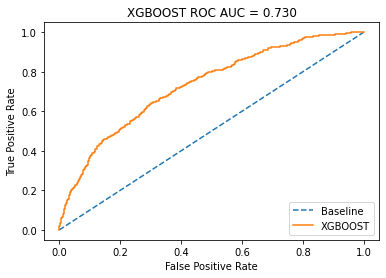

In [ ]:
#Кривая ROC_AUC
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'XGBOOST')
plt.title('XGBOOST ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

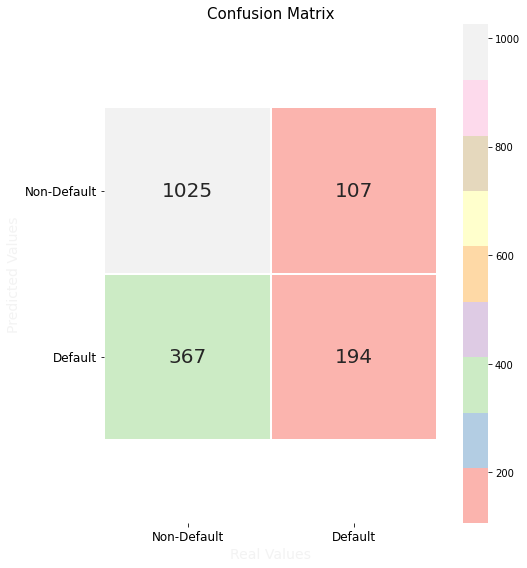

In [ ]:
#Confusion matrix
conf_matr(y_test, y_pred)

In [ ]:
df_comp = cumulated_res(df_comp, 'XGB_pr', y_test, y_pred, probs)
df_comp

Metrics    log_reg        XGB       CatB     XGB_pr
0   Accuracy  70.289427  70.939161  69.816893  72.002363
1  Precision  59.294872  61.855670  59.398496  64.451827
2     Recall  32.976827  32.085561  28.163993  34.581105
3   F1-score  42.382589  42.253521  38.210399  45.011601
4    ROC_AUC  71.595082  72.961899  72.333762  72.984732
5       Gini  43.190164  45.923798  44.667523  45.969464

Подбор признаков для модели улучшил F1-score и критерий Gini. Попробуем еще подобрать параметры для XGBoost:

In [ ]:
#подберем параметры для XGBoost
def hyperopt_xgb_score(params):
    model = xgb.XGBClassifier()
    current_score = cross_val_score(model, X_train, y_train, cv=3).mean()
    print(current_score, params)
    return -current_score
   
    
space_xgb2 = {
            'n_estimators': hp.choice('n_estimators', range(100, 1000)), #количество деревьев
            'eta': hp.quniform('eta', 0.025, 0.5, 0.025), #скорость обучения
            'max_depth':  hp.choice('max_depth', np.arange(1, 20, dtype=int)), #максимальная глубина дерева
            'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1), #минимальное количество наблюдений в листе дерева
            'subsample': hp.quniform('subsample', 0.5, 1, 0.05), # доля объектов обучающей выборки, используемых на каждой итерации
            'gamma': hp.quniform('gamma', 0.5, 1, 0.05), #минимальное уменьшения значения функции потерь
            'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05), #доля переменных, используемых при построении каждого дерева
            'eval_metric': 'gini',
            'objective': 'binary:logistic',
            # Increase this number if you have more cores. Otherwise, remove it and it will default
            # to the maxium number.
            'nthread': 4,
            'booster': 'gbtree', #"dart", #
            'tree_method': 'exact',
            'silent': 1
        }
 
best = fmin(fn=hyperopt_xgb_score, space=space_xgb2, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.7036052009456265
{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eta': 0.45, 'eval_metric': 'gini', 'gamma': 0.9, 'max_depth': 7, 'min_child_weight': 4.0, 'n_estimators': 649, 'nthread': 4, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.8500000000000001, 'tree_method': 'exact'}
0.7036052009456265
{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eta': 0.2, 'eval_metric': 'gini', 'gamma': 0.8, 'max_depth': 18, 'min_child_weight': 2.0, 'n_estimators': 677, 'nthread': 4, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.5, 'tree_method': 'exact'}
0.7036052009456265
{'booster': 'gbtree', 'colsample_bytree': 0.65, 'eta': 0.1, 'eval_metric': 'gini', 'gamma': 0.9500000000000001, 'max_depth': 7, 'min_child_weight': 3.0, 'n_estimators': 137, 'nthread': 4, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.55, 'tree_method': 'exact'}
0.7036052009456265
{'booster': 'gbtree', 'colsample_bytree': 1.0, 'eta': 0.25, 'eval_metric': 'gini', 'gamma': 0.65, 'max_depth': 15

In [ ]:
model = xgb.XGBClassifier(colsample_bytree = 0.8, eta = 0.45, gamma=0.9, max_depth=2, 
                        min_child_weight = 4, n_estimators = 549, subsample = 0.85)

model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eta=0.45, gamma=0.9,
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=4, missing=None, n_estimators=549, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.85, verbosity=1)

In [ ]:
#Предсказываем значения целевой переменной и вероятность 
y_pred = model.predict(X_test)
probs = model.predict_proba(X_test)[:,1]

In [ ]:
# Оценка качества модели
metrics_total(y_test, y_pred, probs)

Metrics       Result  \
P                Positive  1132.000000   
N                Negative   561.000000   
TP          True positive   989.000000   
TN          True Negative   215.000000   
FP         False Positive   346.000000   
FN         False Negative   143.000000   
Accuracy         Accuracy    71.116361   
Precision       Precision    60.055866   
Recall             Recall    38.324421   
F1-score           F-мера    46.789989   
ROC_AUC           ROC_AUC    73.633183   
Gini                 Gini    47.266366   

                                        Description  
P                                       БЕЗ Дефолта  
N                                            Дефолт  
TP                             Истинно НЕ дефолтные  
TN                                Истинно дефолтные  
FP                               Ложно НЕ дефолтные  
FN                                  Ложно дефолтные  
Accuracy        Accuracy=(TP+TN)/(TP+TN+FP+FN)*100%  
Precision                Точность = TP/(TP+FP)*100%  
Recall                    Полнота = TP/(TP+FN)*100%  
F1-score   Среднее гармоническое Precision и Recall  
ROC_AUC                                     ROC-AUC  
Gini                               Коэффициент Gini

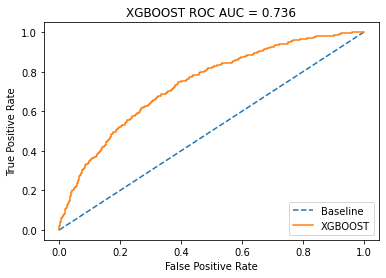

In [ ]:
#Кривая ROC_AUC
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'XGBOOST')
plt.title('XGBOOST ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

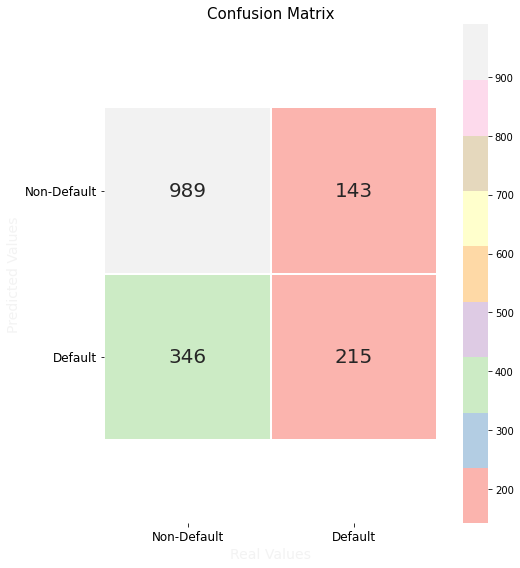

In [ ]:
#Confusion matrix
conf_matr(y_test, y_pred)

In [ ]:
df_comp = cumulated_res(df_comp, 'XGB_pr_par', y_test, y_pred, probs)
df_comp

Metrics    log_reg        XGB       CatB     XGB_pr  XGB_pr_par
0   Accuracy  70.289427  70.939161  69.816893  72.002363   71.116361
1  Precision  59.294872  61.855670  59.398496  64.451827   60.055866
2     Recall  32.976827  32.085561  28.163993  34.581105   38.324421
3   F1-score  42.382589  42.253521  38.210399  45.011601   46.789989
4    ROC_AUC  71.595082  72.961899  72.333762  72.984732   73.633183
5       Gini  43.190164  45.923798  44.667523  45.969464   47.266366

Подбор параметров позволил улучшить полноту, F1 меру и коэффициент Gini, но незначительно снизил точность. Наша модель с подбором параметров лучше всего выявляет факт дефолта и имеет самый высокий критейрий Gini, т.е. лучше всего разделяет классы.

##3.4 Модель CatBoost с подбором признаков:

In [ ]:
model = CatBoostClassifier(iterations=100, random_seed=42)
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=500,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.138367
0:	learn: 0.6670634	test: 0.6673783	best: 0.6673783 (0)	total: 64.7ms	remaining: 6.4s
99:	learn: 0.4214674	test: 0.5608548	best: 0.5591192 (73)	total: 3s	remaining: 0us

bestTest = 0.5591192014
bestIteration = 73

Shrink model to first 74 iterations.


In [ ]:
#Предсказываем значения целевой переменной и вероятность 
y_pred = model.predict(X_test)
probs = model.predict_proba(X_test)[:,1]

In [ ]:
# Оценка качества модели
metrics_total(y_test, y_pred, probs)

Metrics       Result  \
P                Positive  1132.000000   
N                Negative   561.000000   
TP          True positive  1008.000000   
TN          True Negative   194.000000   
FP         False Positive   367.000000   
FN         False Negative   124.000000   
Accuracy         Accuracy    70.998228   
Precision       Precision    61.006289   
Recall             Recall    34.581105   
F1-score           F-мера    44.141069   
ROC_AUC           ROC_AUC    72.765852   
Gini                 Gini    45.531704   

                                        Description  
P                                       БЕЗ Дефолта  
N                                            Дефолт  
TP                             Истинно НЕ дефолтные  
TN                                Истинно дефолтные  
FP                               Ложно НЕ дефолтные  
FN                                  Ложно дефолтные  
Accuracy        Accuracy=(TP+TN)/(TP+TN+FP+FN)*100%  
Precision                Точность = TP/(TP+FP)*100%  
Recall                    Полнота = TP/(TP+FN)*100%  
F1-score   Среднее гармоническое Precision и Recall  
ROC_AUC                                     ROC-AUC  
Gini                               Коэффициент Gini

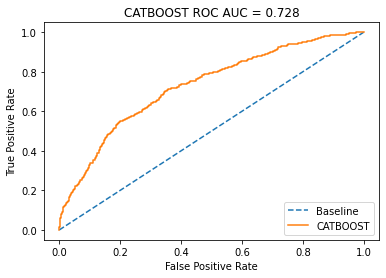

In [ ]:
#Кривая ROC_AUC
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'CATBOOST')
plt.title('CATBOOST ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

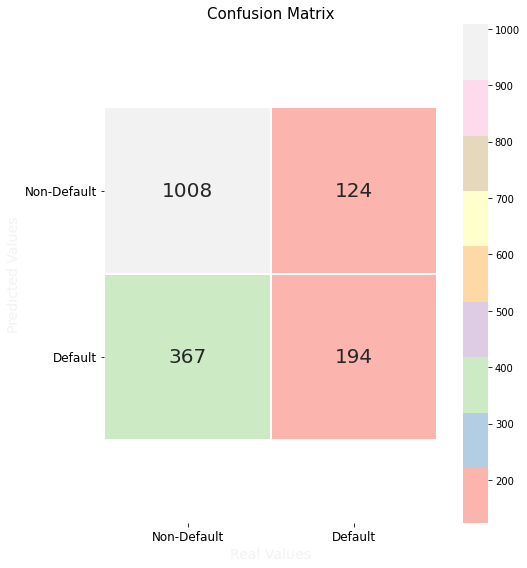

In [ ]:
#Confusion matrix
conf_matr(y_test, y_pred)

In [ ]:
df_comp = cumulated_res(df_comp, 'CatB_pr', y_test, y_pred, probs)
df_comp

Metrics    log_reg        XGB       CatB     XGB_pr  XGB_pr_par  \
0   Accuracy  70.289427  70.939161  69.816893  72.002363   71.116361   
1  Precision  59.294872  61.855670  59.398496  64.451827   60.055866   
2     Recall  32.976827  32.085561  28.163993  34.581105   38.324421   
3   F1-score  42.382589  42.253521  38.210399  45.011601   46.789989   
4    ROC_AUC  71.595082  72.961899  72.333762  72.984732   73.633183   
5       Gini  43.190164  45.923798  44.667523  45.969464   47.266366   

     CatB_pr  
0  70.998228  
1  61.006289  
2  34.581105  
3  44.141069  
4  72.765852  
5  45.531704

Подбор признаков значительно улучшил качество модели CatBoost. F1-score вырос с 38,21% до 44,14%, коэффициент Gini также улучшился с 44.67% до 45.53%. 
Попробуем добавить к модели CatBoost кроссвалидацию:

##3.5 CatBoost + CV

In [149]:
targets = df_for_model1.Default.values
features = [x for x in df_for_model1.columns if x not in ['Default']]

cv = KFold(n_splits=5, random_state=100, shuffle=True)

oof = np.zeros(len(df_for_model1))
train_preds = np.zeros(len(df_for_model1))
y_pred = np.zeros(len(df_for_model1))

models = []


tree_params = {
    'max_depth': 5,
    'eval_metric': 'AUC',
    'loss_function': 'Logloss',
    'random_state': 100,
    'l2_leaf_reg': 1,
    #'task_type': 'GPU' # если имеется GPU с CUDA, то можно ее задействовать, чтобы на порядок ускорить обучение
}


for fold_, (train_idx, val_idx) in enumerate(cv.split(df_for_model1, targets), 1):
    print(f'Training with fold {fold_} started.')
    model = CatBoostClassifier(**tree_params)    
    
    train, val = df_for_model1.iloc[train_idx], df_for_model1.iloc[val_idx]
    
    train_pool = Pool(train[features], train.Default.values)
    val_pool = Pool(val[features], val.Default.values)
    

    model.fit(train_pool, eval_set=[val_pool], early_stopping_rounds=100, verbose_eval=50, use_best_model=True, plot=False)
    
    train_preds[train_idx] += xgb_model.predict_proba(train[features])[:, 1] / (cv.n_splits-1)
    oof[val_idx] = xgb_model.predict_proba(val[features])[:, 1]
    y_pred[val_idx] += xgb_model.predict(val[features])
    models.append(model)
    print(f'Training with fold {fold_} completed.')

Training with fold 1 started.
0:	test: 0.6343734	best: 0.6343734 (0)	total: 22.9ms	remaining: 22.9s
50:	test: 0.7050331	best: 0.7050331 (50)	total: 1.1s	remaining: 20.5s
100:	test: 0.7208193	best: 0.7208193 (100)	total: 2.17s	remaining: 19.4s
150:	test: 0.7247442	best: 0.7248228 (149)	total: 3.26s	remaining: 18.3s
200:	test: 0.7276160	best: 0.7277071 (196)	total: 4.33s	remaining: 17.2s
250:	test: 0.7287681	best: 0.7291580 (245)	total: 5.41s	remaining: 16.2s
300:	test: 0.7310190	best: 0.7312595 (296)	total: 6.47s	remaining: 15s
350:	test: 0.7327009	best: 0.7333532 (345)	total: 7.52s	remaining: 13.9s
400:	test: 0.7333863	best: 0.7340197 (388)	total: 8.58s	remaining: 12.8s
450:	test: 0.7340700	best: 0.7345699 (428)	total: 9.63s	remaining: 11.7s
500:	test: 0.7331269	best: 0.7345699 (428)	total: 10.7s	remaining: 10.6s
550:	test: 0.7347019	best: 0.7349518 (529)	total: 11.7s	remaining: 9.55s
600:	test: 0.7345054	best: 0.7354878 (562)	total: 12.8s	remaining: 8.48s
650:	test: 0.7336472	best: 0.

In [150]:
# Оценка качества модели
print("Accuracy: %.2f%%" % (accuracy_score(targets, y_pred) * 100.0))
print("Precision_score: %.2f%%" % (precision_score(targets, y_pred) * 100.0))
print("Recall_score: %.2f%%" % (recall_score(targets, y_pred) * 100.0))
print("F1_score: %.2f%%" % (f1_score(targets, y_pred) * 100.0))
gini = 2*roc_auc_score(targets, oof)-1
print("Gini: %.2f%%" % (gini * 100.0))

Accuracy: 73.68%
Precision_score: 69.76%
Recall_score: 36.22%
F1_score: 47.69%
Gini: 56.46%


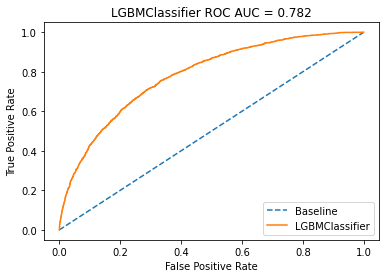

In [151]:
#Кривая ROC_AUC
fpr, tpr, threshold = roc_curve(targets, oof)
roc_auc = roc_auc_score(targets, oof)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'LGBMClassifier')
plt.title('LGBMClassifier ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

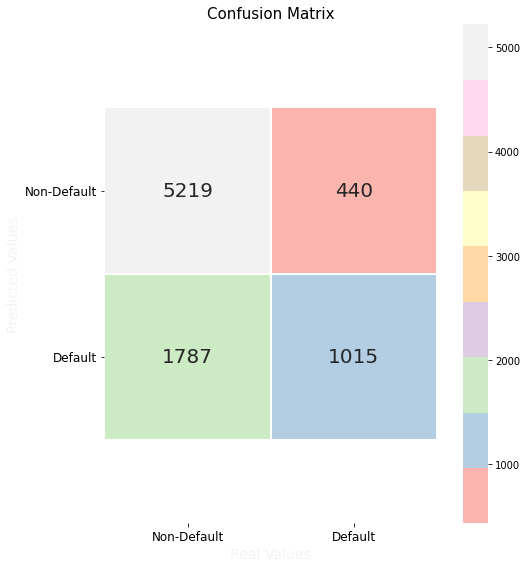

In [152]:
#Confusion matrix
conf_matr(targets, y_pred)

In [153]:
df_comp = cumulated_res(df_comp, 'CatBoost_cv', targets, y_pred, oof)
df_comp

Metrics    log_reg        XGB       CatB     XGB_pr  XGB_pr_par  \
0   Accuracy  70.289427  70.939161  69.816893  72.002363   71.116361   
1  Precision  59.294872  61.855670  59.398496  64.451827   60.055866   
2     Recall  32.976827  32.085561  28.163993  34.581105   38.324421   
3   F1-score  42.382589  42.253521  38.210399  45.011601   46.789989   
4    ROC_AUC  71.595082  72.961899  72.333762  72.984732   73.633183   
5       Gini  43.190164  45.923798  44.667523  45.969464   47.266366   

     CatB_pr  CatBoost_cv  
0  70.998228    73.679234  
1  61.006289    69.759450  
2  34.581105    36.224126  
3  44.141069    47.686164  
4  72.765852    78.231583  
5  45.531704    56.463165

# Выводы:

1. Мы попробовали 3 модели для кредитного скоринга, лучше всего на наших данных себя показала модель XGBoost, поэтому для нее был сделан дополнительный отбор признаков и подбор оптимальных параметров. Также после подбора признаков мы построили модель CatBoost  и сделали на ней кроссвалидацию - этот вариант показал самый лучший результат.
2. После подбора признаков и параметров, модель XGBoost показала критерий Gini  порядка 47%, это говорит о достаточно успешном разделении тех, кто вернет кредит и тех, у кого может случиться дефолт.
3. Благодаря подбору признаков и параметров XGBoost удалось увеличить F1 меру с 42.25% до 46.79%, это говорит о повышении уверенности разделения моделью двух классов к «положительным» и «отрицательным», что особенно релевантно для задачи кредитного скоринга.
4. Самый лучший результат на наших данных показала модель CatBoost  с использованием кроссвалидации. Благодаря подбору признаков и применению кроссвалидции  критерий Gini удалось увеличить с 44.66% до 56.46% - значит, она лучше всего разделяет "положительный" и "отрицательный" классы.